# Regression & Demand Model Estimation
Ecommerce companies suffer from an over abundance of data which comes from different sources, is complied using different methodologies, and rarely tell the same story. In this analysis we focus on a mid-sized ecommerce company that is in the Women's Apparel Space. 

Context - Most ecommerce companies have Seasonal Sales (Black Friday/Cyber Monday) and clearances End of Season, Sample Sales. These sales have a dramatic effect on purchase volumes since prices can drop upto 50% off of MSRP. Further, we can safely assume that women are aware of this practice and adjust their purchase behavior accordingly.
 
This has two implications -
1.     Price and Discount strategies have big impacts on overall profitability. A 1% increase in profitability equates to well over $200K in incremental revenue.
2.     As a company runs media campaigns to build awareness, people will delay their time of purchase to align with a sale cycle. Knowing how a sale will perform given a final price is a key piece of media planning 

## Business Problem 
There are two elements to this problem. 
1.	 How to best account for the effectiveness of media and its KPIs
2.	Can we implement a better price strategy that will increase profitability.

__Approach__ - A Model to Predict Sales (Revenue or Orders) based on Price (List Price, Discount and Transaction Price) and Media Levels. That model can then be used to estimate a demand curve, to understand the impact of an increase in prices on quantity demanded and profit margin. 

Data comes from 4 Sources: 
1. _Google Analytics_ - The worldwide standard for Web Analytics 
    * Date Range: 1/1/2015 - 12/31/2017
    * Last Click Attribution Data by Media Source includes Email, Direct, Organic Social and Search.
    
2. _Google AdWords_ - Google's Advertising products are used by every ecommerce company in the world. 
    * Date Range: 1/1/2015 - 12/31/2017
    * Paid Search, Google Display, and Product Listing Ads (PLA) by Day, By Creative
    
3. _Facebook_ - The Social Media Giant allows brands to reach over 1B People. 
    * Date Range: 2/15/2016 - 12/31/2017
    * Facebook and Instagram Ad Performance Data by Day, By Creative
    
4. _Customer Transaction File_ - This includes actual sales, and data on List Price, Discounts, and Prices Paid. 
    * Date Range: 1/1/2014 - 9/30/2017
    * This is the master file of everyone who purchased, by date, and name.


 
### Stats Model Estimation
This data will be used to estimate a best fit predictive model, which we can then interpret its coefficients to inform the Client of which channels, and which KPIs are the most important. Answering our first Question. 

### Demand Model Estimation
Using that same Best Fit Model, we can use Bootstraps to estimate the demand curve by rerunning the model under different pricing conditions. By Mixing the interplay between MSRP, Discounts, and the final Transaction Price we can understand what is truly driving consumer purchase behavior. 

> H0 - Homo Economicus: People only care about the final 'out-of-pocket' price. They Rationally Perceive Prices.

> H1 - Homo Bargainus: People want to 'get a deal'. EG the utility derived from a 'savings' is greater than their utility from an incremental dollar. EG "I just saved \$100 on this \$500 item"

***
Data Cleaning Steps Taken before import:
1. Facebook
    1. Correct Date dtype to be pandas DateTimes
    2. Df.fillna(0) for all NaN Values. This is the correct value, as Facebook leaves no actions as blanks, but its equivalent to say if no action was taken then 0 actions were taken, this is also how Google presents its data.
    3. Create labels for Target (Audience eg TOF, Mid, Ret)
    4. Create labels for Source (Facebook, Instagram, DPA)
2. Ad Words
    1. Correct Date dtype to be pandas DateTimes
    2. Change Column Names
    3. Create labels for Target (Audience eg TOF, Mid, Ret)
    4. Create labels for Source (Brand, Product, PLA, Display, etc)
3. Analytics
    1. Correct Date dtype to be pandas DateTimes
    2. Change Column Names
    3. Change Source Names
4. Customer File
    1. Drop all PID
    2. Remove Internal Test Rows


In [11]:
%matplotlib inline

import pickle
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import ElasticNet
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cross_validation import train_test_split,  cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_absolute_error, explained_variance_score

# setting matplotlib style and seed
plt.style.use('fivethirtyeight')
np.seed = 2

# Retrieve current working directory (`cwd`)
cwd = os.getcwd()
cwd


"\n%matplotlib inline\n\nimport pickle\nimport os\nimport numpy as np\nimport pandas as pd\nimport seaborn as sns\nimport matplotlib.pyplot as plt\nimport statsmodels.api as sm\n\nfrom sklearn.linear_model import ElasticNet\nfrom sklearn.decomposition import PCA, KernelPCA\nfrom sklearn.cross_validation import train_test_split,  cross_val_score\nfrom sklearn.grid_search import GridSearchCV\nfrom sklearn.metrics import mean_absolute_error, explained_variance_score\n\n# setting matplotlib style and seed\nplt.style.use('fivethirtyeight')\nnp.seed = 2\n\n# Retrieve current working directory (`cwd`)\ncwd = os.getcwd()\ncwd\n"

In [2]:
# Change directory 
os.chdir('.../data')

In [3]:
file = open("fb_all.pkl",'rb')
fb = pickle.load(file)
file.close()

file = open("aw_all.pkl",'rb')
aw = pickle.load(file)
file.close()

file = open("ga_all.pkl",'rb')
ga = pickle.load(file)
file.close()

file = open("cd.pkl",'rb')
cd = pickle.load(file)
file.close()

# AdWords 

All of these files have been preprocessed to an extent, some files are included for later anaysis, but for this project we removed all the creative id fields, and some summary stats that we can not use post data reshaping, and will need to be recreated. 

In [4]:
aw.drop(['CPC','CPM','adGroup','adCampaignID','adCreativeID','campaign'], axis=1, inplace=True)

In [5]:
aw.shape

(1298220, 9)

In [6]:
aw.head()

,clicks,spend,date,impressions,pv,sessions,revenue,orders,campaign_type
0,0,0,2017-01-01,1,0,0,0,0,Search
1,0,0,2017-01-01,5,0,0,0,0,Search
2,0,0,2017-01-01,6,0,0,0,0,Search
3,0,0,2017-01-01,2,0,0,0,0,Search
4,0,0,2017-01-01,1,0,0,0,0,Search


Lets looks at some classic advertising statistics that are used to measure the relative effectiveness of on media type versus another: 

In [2]:
"""awsum = aw.groupby('campaign_type')['clicks','spend', 'impressions','revenue','orders'].sum()
awsum['CPM'] = awsum['spend'] / ( awsum['impressions'] / 1000 ) #Costs per 1K Impressions
awsum['CPA'] = awsum['spend'] / awsum['orders'] # Cost Per Action (Order) 
awsum['CPC'] = awsum['spend'] / awsum['clicks'] # Cost Per Click 
awsum['CTR'] = (awsum['clicks'] / awsum['impressions']) * 100 # Click Through Rate
awsum['ROAS'] =  awsum['revenue'] / awsum['spend'] # Return on Ad Spend
awsum"""
#Data Removed 

"awsum = aw.groupby('campaign_type')['clicks','spend', 'impressions','revenue','orders'].sum()\nawsum['CPM'] = awsum['spend'] / ( awsum['impressions'] / 1000 ) #Costs per 1K Impressions\nawsum['CPA'] = awsum['spend'] / awsum['orders'] # Cost Per Action (Order) \nawsum['CPC'] = awsum['spend'] / awsum['clicks'] # Cost Per Click \nawsum['CTR'] = (awsum['clicks'] / awsum['impressions']) * 100 # Click Through Rate\nawsum['ROAS'] =  awsum['revenue'] / awsum['spend'] # Return on Ad Spend\nawsum"

Ad Words gives us three type of Campaigns -
*	Display - These are remarketing ads that appear as 'Banner Ads' on various Web Sites
*	Search - Most brands buy their own brand terms (Omega, Rayban), as well as any product names (Birkin Bags, iPhones, etc), and occasionally categorical (shoes, handbags, sunglasses)
*	Shopping - These are categorical shopping ads that appear on Google/Bing Shopping sections
*	Video - These are YouTube Videos, this has a been a small area of focus.

Note - To Count as an Order, a person must click on that media and then buy, so for example, someone who clicks on a Display ad almost certainly was on the site previously, possibly even from a Search Ad. But if the LAST CLICK was on a Display ad, it gets ALL of the credit.

Branded Paid Search is traditionally the best ROAS of any media. Display is a cheap form of Media, with very low CPMs, but its also very rare for anyone to click on a display ad, its more about the visibility. Shopping tends to be a lead-generation form of media, targeting new people, but also very high cost per order/action.


For my larger question I want to merge all of the data files based on the daily preformance of all media campaigns. 

In [8]:
awide = pd.pivot_table(aw, 
                       columns=['campaign_type'], 
                       values=['impressions','sessions','pv','clicks','spend'], 
                       index=['date'],  aggfunc=np.sum).fillna(0)

In [9]:
awide.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1096 entries, 2015-01-01 to 2017-12-31
Data columns (total 20 columns):
(impressions, Display)     1096 non-null float64
(impressions, Search)      1096 non-null float64
(impressions, Shopping)    1096 non-null float64
(impressions, Video)       1096 non-null float64
(sessions, Display)        1096 non-null float64
(sessions, Search)         1096 non-null float64
(sessions, Shopping)       1096 non-null float64
(sessions, Video)          1096 non-null float64
(pv, Display)              1096 non-null float64
(pv, Search)               1096 non-null float64
(pv, Shopping)             1096 non-null float64
(pv, Video)                1096 non-null float64
(clicks, Display)          1096 non-null float64
(clicks, Search)           1096 non-null float64
(clicks, Shopping)         1096 non-null float64
(clicks, Video)            1096 non-null float64
(spend, Display)           1096 non-null float64
(spend, Search)            1096 non-null f

# Google Analytics
Another source rich in data, but in need of reshaping

In [10]:
ga.drop(['source','medium','campaign'], axis=1, inplace=True)

In [11]:
ga.shape

(214175, 6)

In [12]:
ga.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214175 entries, 0 to 214174
Data columns (total 6 columns):
channel     214175 non-null object
date        214175 non-null datetime64[ns]
pv          214175 non-null int64
sessions    214175 non-null int64
revenue     214175 non-null int64
orders      214175 non-null int64
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 9.8+ MB


In [13]:
gawide = pd.pivot_table(ga, columns=['channel'], 
                        values=['sessions','pv'], 
                        index=['date'],  
                        aggfunc=np.sum).fillna(0)

In [14]:
gawide.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 470 entries, 2017-01-01 to 2018-04-15
Data columns (total 24 columns):
(sessions, Osearch)        470 non-null float64
(sessions, Osocial)        470 non-null float64
(sessions, Preferral)      470 non-null float64
(sessions, Psearch)        470 non-null float64
(sessions, Psocial)        470 non-null float64
(sessions, affiliatesR)    470 non-null float64
(sessions, apps)           470 non-null float64
(sessions, direct)         470 non-null float64
(sessions, display)        470 non-null float64
(sessions, email)          470 non-null float64
(sessions, other)          470 non-null float64
(sessions, referral)       470 non-null float64
(pv, Osearch)              470 non-null float64
(pv, Osocial)              470 non-null float64
(pv, Preferral)            470 non-null float64
(pv, Psearch)              470 non-null float64
(pv, Psocial)              470 non-null float64
(pv, affiliatesR)          470 non-null float64
(pv, apps)  

# Facebook 
Facebook Data includes both Facebook and Instagram, between 2/15/2016 - 12/31/2017

In [15]:
fb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29951 entries, 0 to 29950
Data columns (total 38 columns):
date                            29951 non-null datetime64[ns]
campaign_id                     29951 non-null int64
adset_id                        29951 non-null int64
ad_id                           29951 non-null int64
ad_name                         29951 non-null object
reach                           29951 non-null int64
impressions                     29951 non-null int64
spend                           29951 non-null float64
shares                          29951 non-null float64
reactions                       29951 non-null float64
comments                        29951 non-null float64
link_clicks                     29951 non-null float64
outbound_clicks                 29951 non-null float64
purchases_1day_view             29951 non-null float64
purchases_1day_click            29951 non-null float64
purchases_7day_click            29951 non-null float64
purchases_7day_

In [3]:
fbsum = fb.groupby('source')['link_clicks','spend', 'impressions',
                             'purchases_value_1day_click','purchases_1day_click',
                            'purchases_value_28day_view','purchases_28day_view'].sum()
fbsum['CPM'] = fbsum['spend'] / ( fbsum['impressions'] / 1000 ) #Costs per 1K Impressions
fbsum['CPA1'] = fbsum['spend'] / fbsum['purchases_1day_click'] # Cost Per Action (1Day Click Order) 
fbsum['CPA28'] = fbsum['spend'] / fbsum['purchases_28day_view'] # Cost Per Action (28Day View Order) 
fbsum['CPC'] = fbsum['spend'] / fbsum['link_clicks'] # Cost Per Click 
fbsum['CTR'] = (fbsum['link_clicks'] / fbsum['impressions']) * 100 # Click Through Rate
fbsum['ROAS1'] =  fbsum['purchases_value_1day_click'] / fbsum['spend'] # Return on Ad Spend 1Day Click
fbsum['ROAS28'] =  fbsum['purchases_value_28day_view'] / fbsum['spend'] # Return on Ad Spend 28Day View
fbsum

#Data Removed

"fbsum = fb.groupby('source')['link_clicks','spend', 'impressions',\n                             'purchases_value_1day_click','purchases_1day_click',\n                            'purchases_value_28day_view','purchases_28day_view'].sum()\nfbsum['CPM'] = fbsum['spend'] / ( fbsum['impressions'] / 1000 ) #Costs per 1K Impressions\nfbsum['CPA1'] = fbsum['spend'] / fbsum['purchases_1day_click'] # Cost Per Action (1Day Click Order) \nfbsum['CPA28'] = fbsum['spend'] / fbsum['purchases_28day_view'] # Cost Per Action (28Day View Order) \nfbsum['CPC'] = fbsum['spend'] / fbsum['link_clicks'] # Cost Per Click \nfbsum['CTR'] = (fbsum['link_clicks'] / fbsum['impressions']) * 100 # Click Through Rate\nfbsum['ROAS1'] =  fbsum['purchases_value_1day_click'] / fbsum['spend'] # Return on Ad Spend 1Day Click\nfbsum['ROAS28'] =  fbsum['purchases_value_28day_view'] / fbsum['spend'] # Return on Ad Spend 28Day View\nfbsum\n"

Facebook and Instagram both cost about the same from a CPM POV, but if you notice their CPC and CTR are inversed, that makes sense, the more clicks you get the lower each individual one costs, given the same CPM.
Facebook uses different methodologies to calculate the value of their ads, and multiple ways to view that value. In this example, we are looking at: 1 Day Clicks - Person CLICKED on an Ad, within 24hrs Person bought a Product. 28 Day View - Person SAW an ad, and within 28days Person bought something.

If you looked at 1Day Click CPAs, they are similar to Google's products, with Facebook a bit more expensive then Search. And Instagram a bit Less then Shopping. But the ROAS and CPAs on 28 View is much better, this is important for two reasons

1.	Instagram Viewers are more a Lead-Gen/Top Of Funnel Tactic
2.	Over a period of 28days a person will be hit with and engage with a multitude of media, not just that one ad view.

Lets see how all of this media looks once its put into a single dataset by sorting performance KPIs by media channel, by day.


In [146]:
fbwide = pd.pivot_table(fb, columns=['source'], 
                        values=['impressions','reach','shares','comments','clicks','spend','purchases_1day_click','purchases_28day_view'], 
                        index=['date'],  
                        aggfunc=np.sum).fillna(0)

In [147]:
fbwide.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 603 entries, 2016-02-13 to 2017-12-31
Data columns (total 14 columns):
(impressions, FB)             603 non-null float64
(impressions, IG)             603 non-null float64
(reach, FB)                   603 non-null float64
(reach, IG)                   603 non-null float64
(shares, FB)                  603 non-null float64
(shares, IG)                  603 non-null float64
(comments, FB)                603 non-null float64
(comments, IG)                603 non-null float64
(spend, FB)                   603 non-null float64
(spend, IG)                   603 non-null float64
(purchases_1day_click, FB)    603 non-null float64
(purchases_1day_click, IG)    603 non-null float64
(purchases_28day_view, FB)    603 non-null float64
(purchases_28day_view, IG)    603 non-null float64
dtypes: float64(14)
memory usage: 70.7 KB


# Consumer Data

In [1]:
cd.describe()
#Data Removed 

The Data in Question: 
1. Subtotal: All-In Price inc Taxes and Shipping
2. Total Price: Basket Price net Taxes and Shipping
3. Discount: Discount is Code or %Off Sale
4. Transaction Amount: Amount Client Receives

Demand Sales = subtotal - discounts

This is already in Daily Average Format.


Rename the Customer Price Date

In [149]:
cd.rename( columns={"Discount Amount" : "discount", 
                "Total Price":"total_price",
                "Transaction Amount":"transaction_amount",
                "SubTotal":"subtotal"
                }, inplace=True)

## Create Targets 
Realistically, I can choose to predict one of two things - 
1. Total Orders for the Day 
2. Total Revenue for the Day 

In [150]:
gaday = pd.pivot_table(ga, 
                       values=['orders','revenue'], 
                       index=['date'],  aggfunc=np.sum)

# Merge Primary Data Files 
GA to AW to FB as All Media Daily (amd)

In [151]:
wide = gawide.merge(awide, left_index=True, right_index=True)
amd = wide.merge(fbwide, left_index=True, right_index=True, how='left').fillna(0)
amd.shape

(1096, 60)

Now I have a bit of cleaning as the Column Headers are MultiIndex and I need them to be 1d, before I can merge the remaining files

In [152]:
amd.columns

MultiIndex(levels=[[u'clicks', u'comments', u'impressions', u'purchases_1day_click', u'purchases_28day_view', u'pv', u'reach', u'sessions', u'shares', u'spend'], [u'Display', u'FB', u'IG', u'Osearch', u'Osocial', u'Preferral', u'Psearch', u'Psocial', u'Search', u'Shopping', u'Video', u'affiliates', u'affiliatesR', u'apps', u'direct', u'display', u'email', u'other', u'referral']],
           labels=[[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 2, 2, 2, 2, 7, 7, 7, 7, 5, 5, 5, 5, 0, 0, 0, 0, 9, 9, 9, 9, 2, 2, 6, 6, 8, 8, 1, 1, 9, 9, 3, 3, 4, 4], [3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 16, 17, 18, 0, 8, 9, 10, 0, 8, 9, 10, 0, 8, 9, 10, 0, 8, 9, 10, 0, 8, 9, 10, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2, 1, 2]],
           names=[None, u'channel'])

First I use a list comprenhension on the Index, and pass that list as the new Columns

In [153]:
names = pd.Index([e[0] + "_" + e[1] for e in amd.columns.tolist()])
amd.columns = names
amd.columns

Index([       u'sessions_Osearch',        u'sessions_Osocial',
            u'sessions_Preferral',        u'sessions_Psearch',
              u'sessions_Psocial',     u'sessions_affiliates',
          u'sessions_affiliatesR',           u'sessions_apps',
               u'sessions_direct',        u'sessions_display',
                u'sessions_email',          u'sessions_other',
             u'sessions_referral',              u'pv_Osearch',
                    u'pv_Osocial',            u'pv_Preferral',
                    u'pv_Psearch',              u'pv_Psocial',
                 u'pv_affiliates',          u'pv_affiliatesR',
                       u'pv_apps',               u'pv_direct',
                    u'pv_display',                u'pv_email',
                      u'pv_other',             u'pv_referral',
           u'impressions_Display',      u'impressions_Search',
          u'impressions_Shopping',       u'impressions_Video',
              u'sessions_Display',         u'sessions_S

## Merge and Consumer Data
Now we merge the recalculated conversion rates, and the customer price data. 

In [154]:
amdcpd = amd.merge(cd, left_index=True, right_index=True)
amdcpd.shape

(1015, 64)

## Create Seasonal Monthly Variables 
Get Dummies for Months, and Drop June to Reduce Colinearity

In [155]:
amdcpd['month'] = amdcpd.index.month
amdcpd.month = amdcpd.month.astype('category')
amdcpd = pd.get_dummies(amdcpd, prefix=['month'])
amdcpd.drop(['month_1'], axis=1, inplace=True)

## Add Target Features

In [156]:
amdcpd = amdcpd.merge(gaday, left_index=True, right_index=True)
amdcpd.shape

(1015, 77)

In [157]:
amdcpd.columns

Index([       u'sessions_Osearch',        u'sessions_Osocial',
            u'sessions_Preferral',        u'sessions_Psearch',
              u'sessions_Psocial',     u'sessions_affiliates',
          u'sessions_affiliatesR',           u'sessions_apps',
               u'sessions_direct',        u'sessions_display',
                u'sessions_email',          u'sessions_other',
             u'sessions_referral',              u'pv_Osearch',
                    u'pv_Osocial',            u'pv_Preferral',
                    u'pv_Psearch',              u'pv_Psocial',
                 u'pv_affiliates',          u'pv_affiliatesR',
                       u'pv_apps',               u'pv_direct',
                    u'pv_display',                u'pv_email',
                      u'pv_other',             u'pv_referral',
           u'impressions_Display',      u'impressions_Search',
          u'impressions_Shopping',       u'impressions_Video',
              u'sessions_Display',         u'sessions_S

In [158]:
amdcpd.shape

(1015, 77)

## Prep Data and Scale
numpy is what is needed to run most SciKit packages. Also, we have a number of outliers that need to be put into check, so we use the Robust Scalers to norm the data to 25-75%. 

In [159]:
# flattening y into a 1-D array X into array
# we start with Revenue
y = np.ravel(amdcpd['revenue']).reshape(-1, 1)
X = amdcpd.drop(['revenue','orders'], axis=1).values

In [160]:
from sklearn import preprocessing
X_scaled = preprocessing.robust_scale(X,)
y_scaled = preprocessing.robust_scale(y,)

In [161]:
#make the splits into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=.3, random_state=0)

# OLS - The Classic
Lets start with where I would have started before: OLS

Some points to make first. This data set is dementional mess, and the overfitting is expected. The purpose is to create a baseline. 

In [162]:
from statsmodels.formula.api import ols
scipym = sm.OLS(y_train, X_train).fit()
print(scipym.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     216.8
Date:                Wed, 11 Apr 2018   Prob (F-statistic):               0.00
Time:                        22:28:29   Log-Likelihood:                -391.62
No. Observations:                 710   AIC:                             933.2
Df Residuals:                     635   BIC:                             1276.
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.2151      0.085      2.518      0.0

In [163]:
y_per_ols_train = scipym.predict(X_train)
y_per_ols = scipym.predict(X_test)
MAE = mean_absolute_error(y_test, y_per_ols,  multioutput='uniform_average')
cmols_train = explained_variance_score(y_train, y_per_ols_train,  multioutput='uniform_average')
cmols_test = explained_variance_score(y_test, y_per_ols,  multioutput='uniform_average')
print("Mean Absolute Error: " + str(MAE))
print("Explained Variance Score Train: {} Test: {}".format(cmols_train,cmols_test ))



Mean Absolute Error: 0.361485100797
Explained Variance Score Train: 0.958574183723 Test: 0.88063308022


Warnings are exactly what we would expect. But as you can see below the result on unseen data is not nearly what we would expect given the about OLS R2 and F statistics. It makes sense to try a different model, like - 

# ElasticNet
One option for dealing with the high deminstionality is to use a Elastic Net that imposes a LASSO penality, and uses a scalar Alpha. 

In [164]:
# Use grid search to tune the parameters:
parametersGrid = {"max_iter": [10, 15, 20, 30, 40],
                  "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  "l1_ratio": np.arange(0.0, 1.0, 0.1)}

eNet = ElasticNet(random_state=2)
grid = GridSearchCV(eNet, parametersGrid, cv=10)
grid.fit(X_train, y_train)
Y_pred_train = grid.predict(X_train)
Y_pred_test = grid.predict(X_test)

In [165]:
print(grid.best_estimator_)
print(grid.best_score_) 
print(grid.best_params_) 

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True,
      l1_ratio=0.90000000000000002, max_iter=20, normalize=False,
      positive=False, precompute=False, random_state=2, selection='cyclic',
      tol=0.0001, warm_start=False)
0.916022337606
{'alpha': 0.001, 'max_iter': 20, 'l1_ratio': 0.90000000000000002}


That looks like a Good Model, but it might be overfit, lets see how it does on the Test Set

In [166]:
MAE_train = mean_absolute_error(y_train, Y_pred_train,  multioutput='uniform_average')
MAE_test = mean_absolute_error(y_test, Y_pred_test,  multioutput='uniform_average')
cm_train = explained_variance_score(y_train, Y_pred_train,  multioutput='uniform_average')
cm_train = explained_variance_score(y_test, Y_pred_test,  multioutput='uniform_average')
print("Mean Absolute Error: {} Test: {}".format(MAE_train,MAE_test ))
print("Explained Variance Score Train: {} Test: {}".format(cmols_train,cmols_test ))



Mean Absolute Error: 0.322570861441 Test: 0.371617322827
Explained Variance Score Train: 0.958574183723 Test: 0.88063308022


This really no better then OLS. Which makes sense, because the l1 Ratio Fell to 0.0

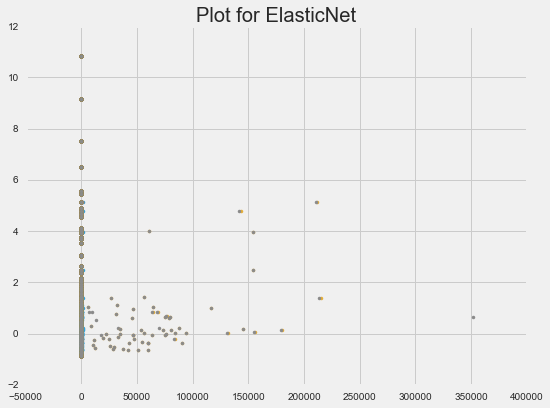

In [167]:
plt.figure(1, figsize=(8, 6))
#plt.plot(X_test, Y_pred, '-')
plt.plot(X_test, y_test,'.')
plt.title('Plot for ElasticNet')
plt.show() 

# ElasticNet + PCA
One Option to reduce the demensions from a number of colinear variables is to use PCA (Principal Component Analysis). 

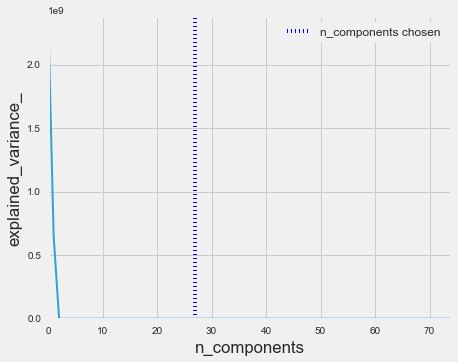

In [168]:
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

eNet = ElasticNet(random_state=2)

pca = decomposition.PCA(random_state=2)
pipe = Pipeline(steps=[('pca', pca), ('eNet', eNet)])

# Plot the PCA spectrum
pca.fit(X_train)

plt.figure(1, figsize=(8, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [25, 26, 27]
svd_solvers = ['full','arpack','randomized']
max_iters = [5, 10, 15, 20, 30,]
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
l1_ratios = np.arange(0.0, 1.0, 0.1)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              pca__svd_solver=svd_solvers,
                              eNet__l1_ratio=l1_ratios,
                              eNet__max_iter=max_iters,
                              eNet__alpha=alphas,
                             ))
estimator.fit(X_train, y_train)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()
Y_pred_pca_train = estimator.predict(X_train)
Y_pred_pca_test = estimator.predict(X_test)

In [169]:
print(estimator.best_estimator_)
print(estimator.best_score_) 
print(estimator.best_params_) 

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=27, random_state=2,
  svd_solver='full', tol=0.0, whiten=False)), ('eNet', ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True,
      l1_ratio=0.20000000000000001, max_iter=5, normalize=False,
      positive=False, precompute=False, random_state=2, selection='cyclic',
      tol=0.0001, warm_start=False))])
0.905995621868
{'pca__n_components': 27, 'eNet__l1_ratio': 0.20000000000000001, 'pca__svd_solver': 'full', 'eNet__max_iter': 5, 'eNet__alpha': 0.1}


We find that we get 27 PCA Components for this model, lets see how well we do with on the Test Data. 

In [170]:
MAE_train = mean_absolute_error(y_train, Y_pred_pca_train,  multioutput='uniform_average')
MAE_test = mean_absolute_error(y_test, Y_pred_pca_test,  multioutput='uniform_average')
cm_train = explained_variance_score(y_train, Y_pred_pca_train,  multioutput='uniform_average')
cm_train = explained_variance_score(y_test, Y_pred_pca_test,  multioutput='uniform_average')
print("Mean Absolute Error: {} Test: {}".format(MAE_train,MAE_test ))
print("Explained Variance Score Train: {} Test: {}".format(cmols_train,cmols_test ))

Mean Absolute Error: 0.367793373051 Test: 0.379381452002
Explained Variance Score Train: 0.958574183723 Test: 0.88063308022


This exhibits the same Explained Variance, and the Mean Absoult Error is slightly higher than the regular Elastic Net. So lets look at how confident we are in the hyper-paramters we have chosen with some KFold Test.

In [171]:
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import KFold

In [172]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
eNet_cv = ElasticNetCV(alphas=alphas, random_state=0)
k_fold = KFold(10)

print("How much can you trust the selection of alpha?")
print()
print("Alpha parameters maximising the generalization score on different")
print("subsets of the data:")
for k, (train, test) in enumerate(k_fold.split(X, y)):
    eNet_cv.fit(X[train], y[train])
    print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
          format(k, eNet_cv.alpha_, eNet_cv.score(X[test], y[test])))

How much can you trust the selection of alpha?
()
Alpha parameters maximising the generalization score on different
subsets of the data:
[fold 0] alpha: 0.00010, score: 0.47461
[fold 1] alpha: 100.00000, score: 0.77543
[fold 2] alpha: 100.00000, score: 0.67257
[fold 3] alpha: 100.00000, score: 0.92134
[fold 4] alpha: 100.00000, score: 0.93106
[fold 5] alpha: 100.00000, score: 0.85579
[fold 6] alpha: 10.00000, score: 0.94067
[fold 7] alpha: 100.00000, score: 0.68432
[fold 8] alpha: 100.00000, score: 0.92129
[fold 9] alpha: 100.00000, score: 0.72852


The answer is not much. Alpha moves around and 100 was not the original alpha, but it is choosen multiple times. Maybe we can estimate our hyperparameters visually.  
    

In [173]:
def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv = 5))
    return(rmse)

In [174]:
from itertools import product
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
l1_ratios = [0.8,0.7,0.6,0.5, 0.4, 0.3, 0.2, 0.1]
cv_elastic = [rmse_cv(ElasticNet(alpha = alpha, l1_ratio=l1_ratio)).mean() 
            for (alpha, l1_ratio) in product(alphas, l1_ratios)]

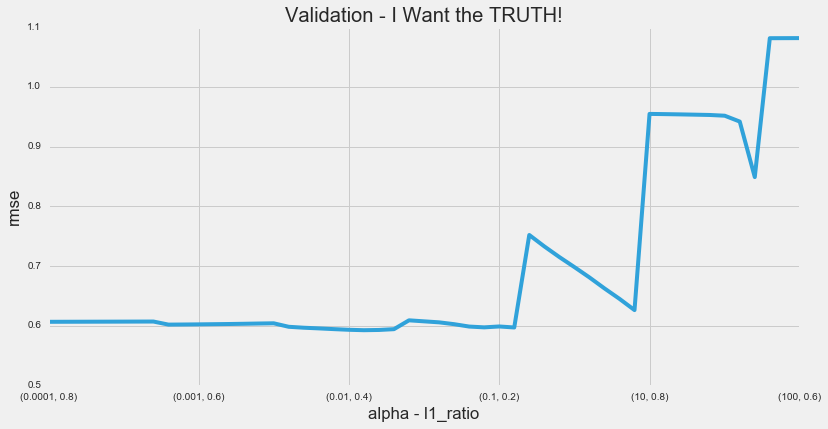

In [175]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))
p_cv_elastic = pd.Series(cv_elastic, index = idx)
p_cv_elastic.plot(title = "Validation - I Want the TRUTH!")
plt.xlim(0.0,50.0)
plt.xlabel("alpha - l1_ratio")
plt.ylabel("rmse")

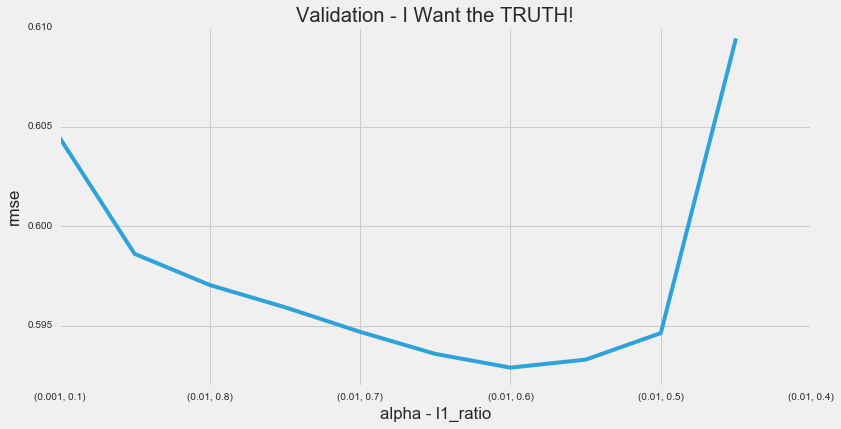

In [176]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))[15:25]
p_cv_elastic = pd.Series(cv_elastic[15:25], index = idx)
p_cv_elastic.plot(title = "Validation - I Want the TRUTH!")
plt.xlim(0.0,10.0)
plt.xlabel("alpha - l1_ratio")
plt.ylabel("rmse")

In [177]:
#make the splits into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=.3, random_state=0)

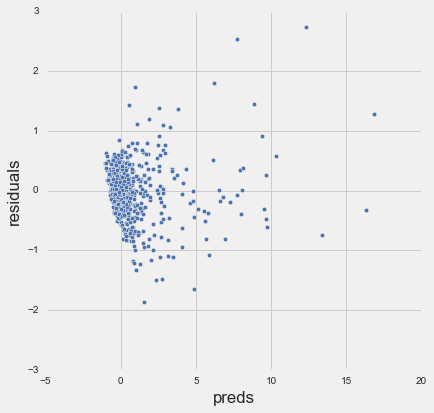

In [178]:
elastic = ElasticNet(alpha=0.01, l1_ratio=0.6)
elastic.fit(X_train, y_train)


#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":elastic.predict(X_train),
                      "true":y_train.ravel()})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

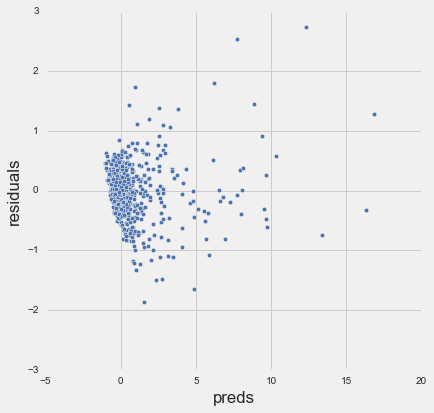

In [179]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds_test = pd.DataFrame({"preds":elastic.predict(X_test),
                      "true":y_test.ravel()})
preds_test["residuals"] = preds_test["true"] - preds_test["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

We still see quite a few outliers in the residual errors, but what are the test numbers? 


In [180]:
MAE_test = mean_absolute_error(preds_test['true'], preds_test['preds'],  multioutput='uniform_average')
MAE_train = mean_absolute_error(preds['true'], preds['preds'],  multioutput='uniform_average')
print("Mean Absolute Error: Train:{} Test: {} ".format(MAE_train,MAE_test ))

evs_test = explained_variance_score(preds_test['true'], preds_test['preds'],  multioutput='uniform_average')
evs_train = explained_variance_score(preds['true'], preds['preds'],  multioutput='uniform_average')
print("Explained Variance Score Train:{} Test: {} ".format(evs_train,evs_test ))
rmse = np.sqrt(np.mean((preds['true']-preds['preds'])**2))
print('RMSE: {0:.4f}'.format(rmse))
from sklearn.metrics import r2_score
print('R^2 train: %.3f' %  r2_score(preds['true'], preds['preds']))
coef = pd.Series(elastic.coef_, index = amdcpd.columns[:-2])
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Mean Absolute Error: Train:0.310726588521 Test: 0.356854973824 
Explained Variance Score Train:0.954082100909 Test: 0.886087156558 
RMSE: 0.4418
R^2 train: 0.954
Elastic Net picked 58 variables and eliminated the other 17 variables


WOW(!) 95% Explained Variance, and the lowest MAE we have seen. It also l1-crushed 19 variables. 

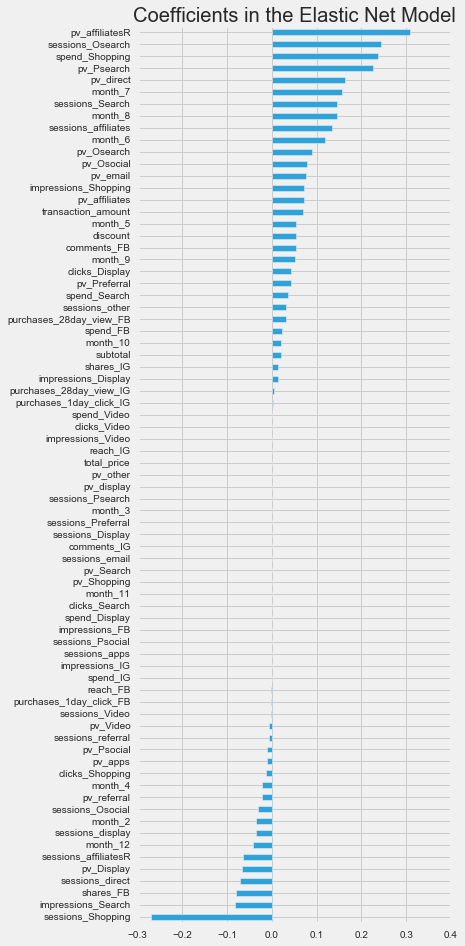

In [181]:
imp_coef = coef.sort_values()
plt.rcParams['figure.figsize'] = (5.0, 15.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model")

In [182]:
#Combine ElasticNet with PCA

In [183]:
from sklearn import preprocessing
# flattening y into a 1-D array X into array
# we start with Revenue
y = np.ravel(amdcpd['revenue']).reshape(-1, 1)
X = amdcpd.drop(['revenue','orders'], axis=1).values
X_scaled = preprocessing.robust_scale(X,)
y_scaled = preprocessing.robust_scale(y,)
#make the splits into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=.3, random_state=0)

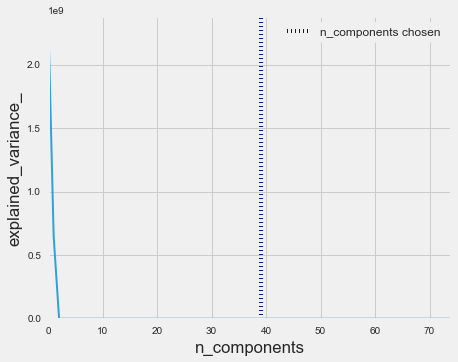

In [184]:
eNet = ElasticNet(random_state=2, alpha=0.01, l1_ratio=0.6)
pca = decomposition.PCA(random_state=2)
pipe = Pipeline(steps=[('pca', pca), ('eNet', eNet)])

# Plot the PCA spectrum
pca.fit(X_train)

plt.figure(1, figsize=(8, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [37, 38, 39, 40, 41, 42, 43, 44, 45]
max_iters = [1, 5, 10, 15]

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              eNet__max_iter=max_iters,
                             ))
estimator.fit(X_train, y_train)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()
Y_pred_pca = estimator.predict(X_test)

In [185]:
print(estimator.best_estimator_)
print(estimator.best_score_) 
print(estimator.best_params_) 

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=39, random_state=2,
  svd_solver='auto', tol=0.0, whiten=False)), ('eNet', ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.6,
      max_iter=1, normalize=False, positive=False, precompute=False,
      random_state=2, selection='cyclic', tol=0.0001, warm_start=False))])
0.916915775308
{'pca__n_components': 39, 'eNet__max_iter': 1}


In [186]:
MAE_train = mean_absolute_error(y_train, Y_pred_pca_train,  multioutput='uniform_average')
MAE_test = mean_absolute_error(y_test, Y_pred_pca_test,  multioutput='uniform_average')
cm_train = explained_variance_score(y_train, Y_pred_pca_train,  multioutput='uniform_average')
cm_train = explained_variance_score(y_test, Y_pred_pca_test,  multioutput='uniform_average')
print("Mean Absolute Error: {} Test: {}".format(MAE_train,MAE_test ))
print("Explained Variance Score Train: {} Test: {}".format(cmols_train,cmols_test ))

Mean Absolute Error: 0.367793373051 Test: 0.379381452002
Explained Variance Score Train: 0.958574183723 Test: 0.88063308022


## The Most Important KPIs
Here is the answer to our first question, Affiliates and Search appear in multiple forms, so too do the summer Months of July and August (These are End of Season Sales and the Launch of Fall Collections). Price Factors also make appearances under transaction amount, subtotal and discounts. And finally, Facebook KPIs of Traffic, Comments, and 28 Day View Purchase Windows. 

Things that are negatively impacting are Shopping Sessions and Clicks (This is a mystery for later exploration). But also Q1 which is Dec-Feb is a known low season. Also, April is the only month with no sales.


In [187]:
#make the splits into train and test
#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=.3, random_state=0)

Computing regularization path using the elastic net...


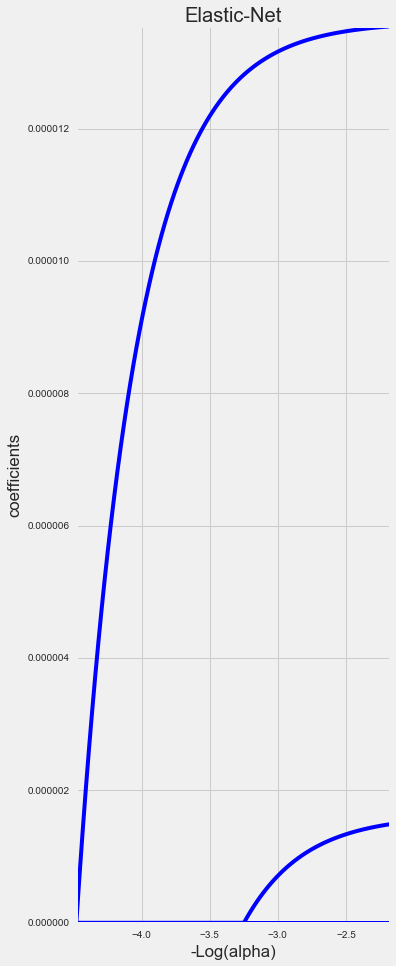

In [188]:
from sklearn.linear_model import enet_path
from itertools import cycle

eps = 5e-3  # the smaller it is the longer is the path

print("Computing regularization path using the elastic net...")
alphas_enet, coefs_enet, _ = enet_path(
    X_train, y_train, eps=eps, alpha=0.01, l1_ratio=0.6, fit_intercept=False)

plt.figure(1)
plt.rcParams['figure.figsize'] = (10.0, 20.0)
ax = plt.gca()

colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_enet = -np.log10(alphas_enet)
for (coef_e, c) in zip(coefs_enet, colors):
    l1 = plt.plot(neg_log_alphas_enet, np.transpose(coef_e), c=c)

plt.xlabel('-Log(alpha)')
plt.ylabel('coefficients')
plt.title('Elastic-Net')
#plt.xlim(0.0,10.0)
#plt.legend(coef_e,loc='lower left')
plt.axis('tight')
plt.show()

# Orders
Lets see how we do with Orders as the predicted feature


In [189]:

# flattening y into a 1-D array X into array
# we now try to estimate Orders
y = np.ravel(amdcpd['orders']).reshape(-1, 1)
X = amdcpd.drop(['revenue','orders'], axis=1).values

X_scaled = preprocessing.robust_scale(X,)
y_scaled = preprocessing.robust_scale(y,)

#make the splits into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=.3, random_state=0)

In [190]:
# Use grid search to tune the parameters:
parametersGrid = {"max_iter": [10, 15, 20, 30, 40],
                  "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  "l1_ratio": np.arange(0.0, 1.0, 0.1)}

eNet = ElasticNet(random_state=2)
grid = GridSearchCV(eNet, parametersGrid, cv=10)
grid.fit(X_train, y_train)
Y_pred_test = grid.predict(X_test)     
Y_pred_train = grid.predict(X_train) 

In [191]:
print(grid.best_estimator_)
print(grid.best_score_) 
print(grid.best_params_) 


MAE_train = mean_absolute_error(y_train, Y_pred_train,  multioutput='uniform_average')
MAE_test = mean_absolute_error(y_test, Y_pred_test,  multioutput='uniform_average')
cm_train = explained_variance_score(y_train, Y_pred_train,  multioutput='uniform_average')
cm_train = explained_variance_score(y_test, Y_pred_test,  multioutput='uniform_average')
print("Mean Absolute Error: {} Test: {}".format(MAE_train,MAE_test ))
print("Explained Variance Score Train: {} Test: {}".format(cmols_train,cmols_test ))

ElasticNet(alpha=1, copy_X=True, fit_intercept=True, l1_ratio=0.0,
      max_iter=20, normalize=False, positive=False, precompute=False,
      random_state=2, selection='cyclic', tol=0.0001, warm_start=False)
0.909296458555
{'alpha': 1, 'max_iter': 20, 'l1_ratio': 0.0}
Mean Absolute Error: 0.353967141966 Test: 0.396385083852
Explained Variance Score Train: 0.958574183723 Test: 0.88063308022


This is has an l1 that goes straight to 0.0, meaning that the LASSO part is not in play, and we are looking at an OLS on Net, lets see how well the Alpha Behaves. 

In [192]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
eNet_cv = ElasticNetCV(alphas=alphas, random_state=0)
k_fold = KFold(10)

print("How much can you trust the selection of alpha?")
print()
print("Alpha parameters maximising the generalization score on different")
print("subsets of the data:")
for k, (train, test) in enumerate(k_fold.split(X, y)):
    eNet_cv.fit(X[train], y[train])
    print("[fold {0}] alpha: {1:.5f}, score: {2:.5f}".
          format(k, eNet_cv.alpha_, eNet_cv.score(X[test], y[test])))

How much can you trust the selection of alpha?
()
Alpha parameters maximising the generalization score on different
subsets of the data:
[fold 0] alpha: 100.00000, score: 0.34805
[fold 1] alpha: 100.00000, score: 0.77297
[fold 2] alpha: 100.00000, score: 0.54016
[fold 3] alpha: 100.00000, score: 0.89891
[fold 4] alpha: 100.00000, score: 0.93125
[fold 5] alpha: 100.00000, score: 0.85864
[fold 6] alpha: 100.00000, score: 0.93402
[fold 7] alpha: 100.00000, score: 0.85443
[fold 8] alpha: 100.00000, score: 0.93683
[fold 9] alpha: 100.00000, score: 0.82557


Actually, pretty good this is much more contained than that of the Revenue Predictor, lets see if we can't get these paramters in better shape.  

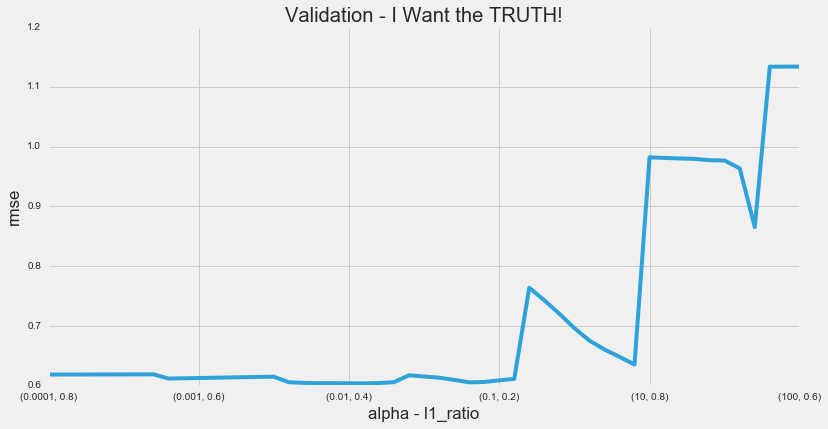

In [193]:
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
l1_ratios = [0.8,0.7,0.6,0.5, 0.4, 0.3, 0.2, 0.1]
cv_elastic = [rmse_cv(ElasticNet(alpha = alpha, l1_ratio=l1_ratio)).mean() 
            for (alpha, l1_ratio) in product(alphas, l1_ratios)]
plt.rcParams['figure.figsize'] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))
p_cv_elastic = pd.Series(cv_elastic, index = idx)
p_cv_elastic.plot(title = "Validation - I Want the TRUTH!")
plt.xlim(0.0,50.0)
plt.xlabel("alpha - l1_ratio")
plt.ylabel("rmse")

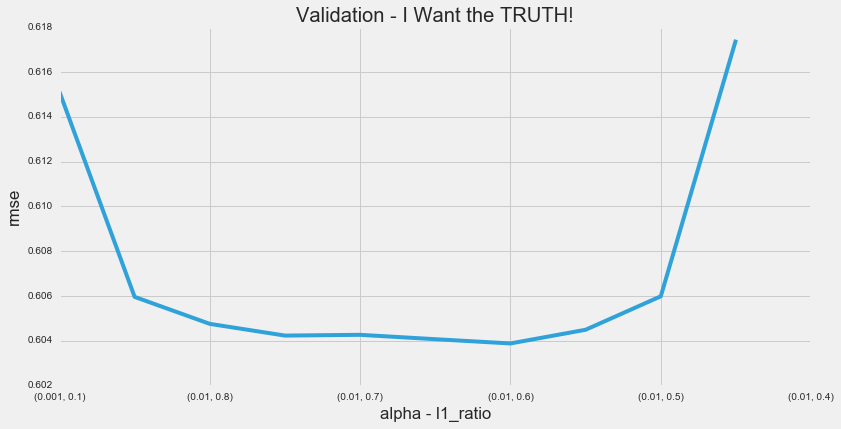

In [194]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
idx = list(product(alphas, l1_ratios))[15:25]
p_cv_elastic = pd.Series(cv_elastic[15:25], index = idx)
p_cv_elastic.plot(title = "Validation - I Want the TRUTH!")
plt.xlim(0.0,10.0)
plt.xlabel("alpha - l1_ratio")
plt.ylabel("rmse")

NOTE - these are the same hyperparameters that we saw on the Revenue Model. 

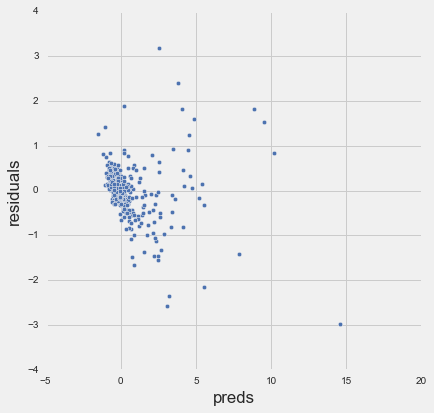

In [195]:
bestfit_o = ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.6,
      max_iter=30, normalize=False, positive=False, precompute=False,
      random_state=2, selection='cyclic', tol=0.0001, warm_start=False)
bestfit_o.fit(X_train, y_train)

#let's look at the residuals as well:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({"preds":bestfit_o.predict(X_test), "true":y_test.ravel()})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

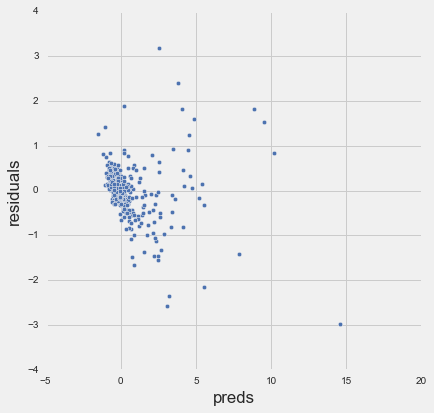

In [196]:
plt.rcParams['figure.figsize'] = (6.0, 6.0)

preds_test = pd.DataFrame({"preds":elastic.predict(X_test),
                      "true":y_test.ravel()})
preds_test["residuals"] = preds_test["true"] - preds_test["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

Mean Absolute Error: Train:0.414570071019 Test: 0.449498072831 
Explained Variance Score Train:0.88149277267 Test: 0.848695339479 
RMSE: 0.6347
R^2 train: 0.881
Elastic Net picked 58 variables and eliminated the other 17 variables


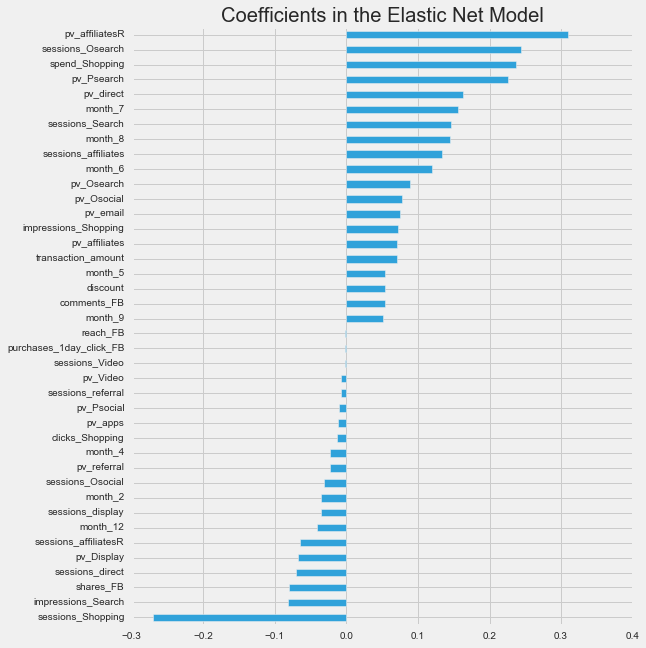

In [197]:
MAE_test = mean_absolute_error(preds_test['true'], preds_test['preds'],  multioutput='uniform_average')
MAE_train = mean_absolute_error(preds['true'], preds['preds'],  multioutput='uniform_average')
print("Mean Absolute Error: Train:{} Test: {} ".format(MAE_train,MAE_test ))

evs_test = explained_variance_score(preds_test['true'], preds_test['preds'],  multioutput='uniform_average')
evs_train = explained_variance_score(preds['true'], preds['preds'],  multioutput='uniform_average')
print("Explained Variance Score Train:{} Test: {} ".format(evs_train,evs_test ))
rmse = np.sqrt(np.mean((preds['true']-preds['preds'])**2))
print('RMSE: {0:.4f}'.format(rmse))
from sklearn.metrics import r2_score
print('R^2 train: %.3f' %  r2_score(preds['true'], preds['preds']))
coef = pd.Series(elastic.coef_, index = amdcpd.columns[:-2])
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(20),
                     coef.sort_values().tail(20)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model")

While this killed off fewer variables, its overall performance is markedly worse then the Revenue Model 

# Variance Inflation Factor
PCA is the new black, but one can also use another demension reduction method wherein you calculated the Variance Inflation, and discard any that are less then some threshold, in the case we use 5.0, which is a standard heuristic similar to p-value < 0.05 

In [198]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5.0):
    variables = range(X.shape[1]) # in Python3 use list(range(X.shape[1]))
    dropped=True
    while dropped:
        dropped=False
        vif = [variance_inflation_factor(X[variables].values, ix) for ix in range(X[variables].shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[variables].columns[maxloc] + '\' at index: ' + str(maxloc))
            del variables[maxloc]
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[variables]

In [199]:
limitvar = calculate_vif_(amdcpd, thresh=5.0)

dropping 'impressions_IG' at index: 47
dropping 'pv_Psearch' at index: 16
dropping 'sessions_Search' at index: 30
dropping 'total_price' at index: 59
dropping 'sessions_Video' at index: 31
dropping 'pv_Osearch' at index: 13
dropping 'sessions_Psearch' at index: 3
dropping 'clicks_Search' at index: 34
dropping 'subtotal' at index: 54
dropping 'sessions_Shopping' at index: 28
dropping 'sessions_Psocial' at index: 3
dropping 'pv_direct' at index: 17
dropping 'clicks_Shopping' at index: 31
dropping 'pv_display' at index: 17
dropping 'orders' at index: 61
dropping 'pv_affiliates' at index: 14
dropping 'sessions_Osocial' at index: 1
dropping 'sessions_Preferral' at index: 1
dropping 'sessions_Osearch' at index: 0
dropping 'pv_email' at index: 13
dropping 'sessions_Display' at index: 19
dropping 'pv_other' at index: 13
dropping 'pv_apps' at index: 12
dropping 'sessions_referral' at index: 7
dropping 'sessions_affiliatesR' at index: 1
dropping 'pv_Search' at index: 16
dropping 'reach_FB' at in

In [200]:
limitvar.shape

(1015, 33)

We have 33 remaining variables, one less than the 34 that the LASSO killed off in the Orders Model Above. So it would appear that they are working in a similar fashion. 

In [201]:
#lets be explicit about our data set. 
# flattening y into a 1-D array X into array
# we start with Revenue, again
y = np.ravel(amdcpd['revenue'])
X = limitvar
#make the splits into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=2)


In [202]:
scipym = sm.OLS(y_train, X_train).fit()
print(scipym.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     340.8
Date:                Thu, 12 Apr 2018   Prob (F-statistic):               0.00
Time:                        01:00:04   Log-Likelihood:                -8113.6
No. Observations:                 710   AIC:                         1.629e+04
Df Residuals:                     677   BIC:                         1.644e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
sessions_affiliates       

In [205]:
op = scipym.summary()


In [231]:
op

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.943
Model:                            OLS   Adj. R-squared:                  0.940
Method:                 Least Squares   F-statistic:                     340.8
Date:                Thu, 12 Apr 2018   Prob (F-statistic):               0.00
Time:                        01:04:17   Log-Likelihood:                -8113.6
No. Observations:                 710   AIC:                         1.629e+04
Df Residuals:                     677   BIC:                         1.644e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
sessions_affiliates         4.5970      0.324     14.176      0.000         3.960     5.234
sessions_apps             -10.8250     12.550     -0.863      0.389       -35.467    13.817
sessions_email              1.4672      0.208      7.058      0.000         1.059     1.875
sessions_other              1.0610      0.731      1.451      0.147        -0.375     2.497
pv_Preferral                6.4831      2.564      2.529      0.012         1.449    11.517
pv_affiliatesR              0.7026      0.042     16.700      0.000         0.620     0.785
pv_referral                 1.4712      0.110     13.373      0.000         1.255     1.687
impressions_Display         0.0255      0.010      2.659      0.008         0.007     0.044
impressions_Search         -0.0833      0.031     -2.712      0.007        -0.144    -0.023
impressions_Shopping        0.0359      0.017      2.066      0.039         0.002     0.070
impressions_Video           0.2052      0.057      3.617      0.000         0.094     0.317
pv_Display                 -0.3045      0.684     -0.445      0.656        -1.648     1.039
pv_Video                 -401.0021    121.629     -3.297      0.001      -639.818  -162.186
spend_Video                 7.0165      9.415      0.745      0.456       -11.469    25.502
impressions_FB             -0.0110      0.012     -0.909      0.364        -0.035     0.013
shares_FB                  82.5074    147.883      0.558      0.577      -207.857   372.872
shares_IG                -617.8689    756.369     -0.817      0.414     -2102.980   867.242
comments_IG              -928.8044   1013.312     -0.917      0.360     -2918.416  1060.808
purchases_1day_click_IG  1171.5189    263.923      4.439      0.000       653.312  1689.725
purchases_28day_view_FB   227.3619     18.152     12.525      0.000       191.721   263.003
purchases_28day_view_IG    64.6091     57.541      1.123      0.262       -48.371   177.589
discount                  182.4318     38.293      4.764      0.000       107.245   257.619
month_2                  1.161e+04   3147.472      3.689      0.000      5431.545  1.78e+04
month_3                  1.788e+04   3424.285      5.221      0.000      1.12e+04  2.46e+04
month_4                  9599.1309   3556.023      2.699      0.007      2616.971  1.66e+04
month_5                  1.572e+04   3313.793      4.744      0.000      9214.779  2.22e+04
month_6                  1.414e+04   3511.081      4.028      0.000      7247.854   2.1e+04
month_7                  1.091e+04   3424.091      3.185      0.002      4184.253  1.76e+04
month_8                  1.837e+04   3373.279      5.447      0.000      1.18e+04   2.5e+04
month_9                  1.573e+04   3425.114      4.593      0.000      9006.628  2.25e+04
month_10                 1.613e+04   3726.193  

## OLS output 
We see the same problems as before with and over fit R^2 and collinearity issues in the warning

## ElasticNet

In [208]:
#set Grid Paramaters 
parametersGrid = {"max_iter": [1, 5, 10, 15, 20],
                  "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                  "l1_ratio": np.arange(0.0, 1.0, 0.1)}

eNet = ElasticNet(random_state=2)
grid = GridSearchCV(eNet, parametersGrid, cv=10)
grid.fit(X_train, y_train)
Y_pred = grid.predict(X_test)

In [209]:
print(grid.best_estimator_)
print(grid.best_score_) 
print(grid.best_params_) 

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True,
      l1_ratio=0.60000000000000009, max_iter=10, normalize=False,
      positive=False, precompute=False, random_state=2, selection='cyclic',
      tol=0.0001, warm_start=False)
0.817687476186
{'alpha': 0.01, 'max_iter': 10, 'l1_ratio': 0.60000000000000009}


In [210]:
Y_pred_test = grid.predict(X_test)     
Y_pred_train = grid.predict(X_train) 
MAE_train = mean_absolute_error(y_train, Y_pred_train,  multioutput='uniform_average')
MAE_test = mean_absolute_error(y_test, Y_pred_test,  multioutput='uniform_average')
cm_train = explained_variance_score(y_train, Y_pred_train,  multioutput='uniform_average')
cm_train = explained_variance_score(y_test, Y_pred_test,  multioutput='uniform_average')
print("Mean Absolute Error: {} Test: {}".format(MAE_train,MAE_test ))
print("Explained Variance Score Train: {} Test: {}".format(cmols_train,cmols_test ))


coef = pd.Series(grid.coef_, index = amdcpd.columns[:-2])
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(20),
                     coef.sort_values().tail(20)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model")

Mean Absolute Error: 13943.8108982 Test: 16175.5196532
Explained Variance Score Train: 0.958574183723 Test: 0.88063308022


AttributeError: 'GridSearchCV' object has no attribute 'coef_'

In [338]:
bestfit_o = ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.6,
      max_iter=30, normalize=False, positive=False, precompute=False,
      random_state=2, selection='cyclic', tol=0.0001, warm_start=False)
bestfit_o.fit(X_train, y_train)

ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True, l1_ratio=0.6,
      max_iter=30, normalize=False, positive=False, precompute=False,
      random_state=2, selection='cyclic', tol=0.0001, warm_start=False)

Mean Absolute Error: 13920.2074925 Test: 16135.7383913
Explained Variance Score Train: 0.958574183723 Test: 0.88063308022
Elastic Net picked 33 variables and eliminated the other 0 variables


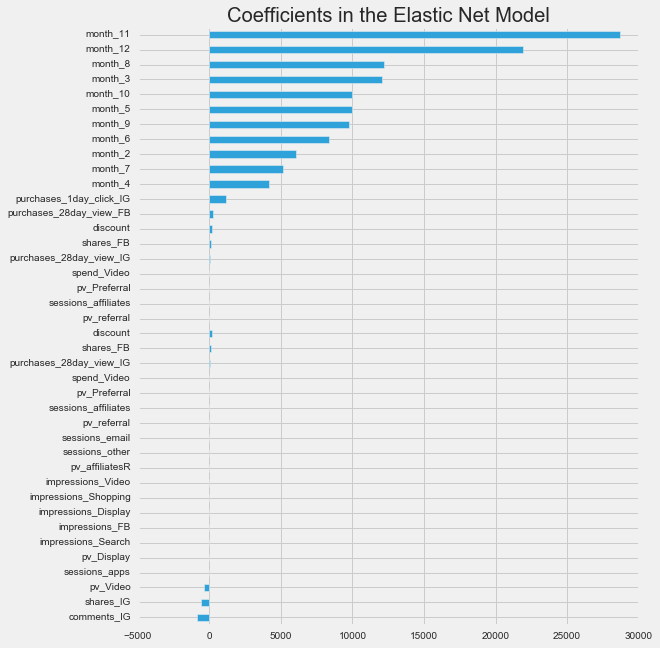

In [339]:
Y_pred_test = bestfit_o.predict(X_test)     
Y_pred_train = bestfit_o.predict(X_train) 
MAE_train = mean_absolute_error(y_train, Y_pred_train,  multioutput='uniform_average')
MAE_test = mean_absolute_error(y_test, Y_pred_test,  multioutput='uniform_average')
cm_train = explained_variance_score(y_train, Y_pred_train,  multioutput='uniform_average')
cm_train = explained_variance_score(y_test, Y_pred_test,  multioutput='uniform_average')
print("Mean Absolute Error: {} Test: {}".format(MAE_train,MAE_test ))
print("Explained Variance Score Train: {} Test: {}".format(cmols_train,cmols_test ))


coef = pd.Series(bestfit_o.coef_, index = limitvar.columns[:])
print("Elastic Net picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

imp_coef = pd.concat([coef.sort_values().head(20),
                     coef.sort_values().tail(20)])
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model")

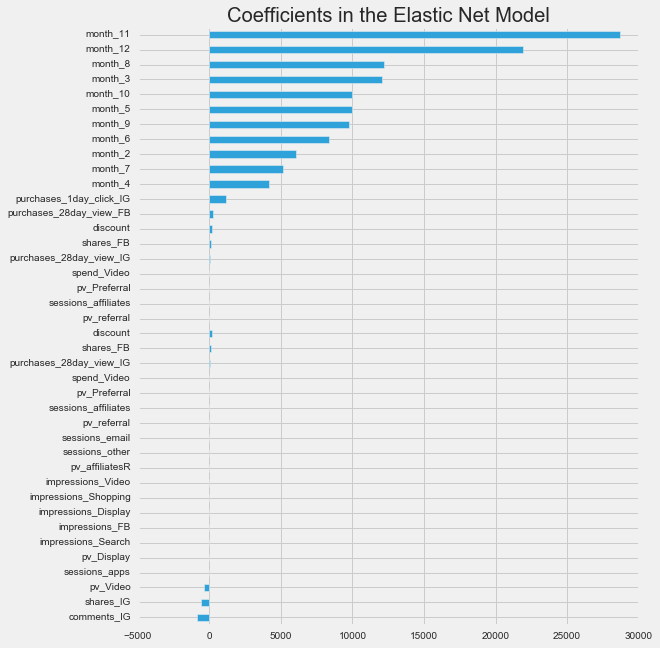

In [340]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Elastic Net Model")

In [341]:
months = coef[-11:]

In [342]:
months = pd.DataFrame(months)

In [343]:
months

,0
month_2,6027.878830
month_3,12096.423475
month_4,4148.448747
month_5,9940.054282
month_6,8360.472585
month_7,5151.132487
month_8,12225.349898
month_9,9745.943059
month_10,9984.747886
month_11,28717.098397


In [344]:
months.columns = ['value']
months

,value
month_2,6027.878830
month_3,12096.423475
month_4,4148.448747
month_5,9940.054282
month_6,8360.472585
month_7,5151.132487
month_8,12225.349898
month_9,9745.943059
month_10,9984.747886
month_11,28717.098397


In [345]:
months['ci'] = [3147.472, 3424.285, 556.023, 3313.793, 3511.081, 3424.091, 3373.279, 3425.114,3726.193,4634.891,4081.393]

In [346]:
months['mths'] = [2,3,4,5,6,7,8,9,10,11,12]

In [351]:
months['ci'] = months['ci'] /10
months['value'] = months['value'] /10


In [352]:
months['min'] = months['value'] - months['ci']
months['max'] = months['value'] + months['ci']

In [353]:
months

,value,ci,mths,min,max
month_2,602.787883,314.7472,2,288.040683,917.535083
month_3,1209.642348,342.4285,3,867.213848,1552.070848
month_4,414.844875,55.6023,4,359.242575,470.447175
month_5,994.005428,331.3793,5,662.626128,1325.384728
month_6,836.047258,351.1081,6,484.939158,1187.155358
month_7,515.113249,342.4091,7,172.704149,857.522349
month_8,1222.534990,337.3279,8,885.207090,1559.862890
month_9,974.594306,342.5114,9,632.082906,1317.105706
month_10,998.474789,372.6193,10,625.855489,1371.094089
month_11,2871.709840,463.4891,11,2408.220740,3335.198940


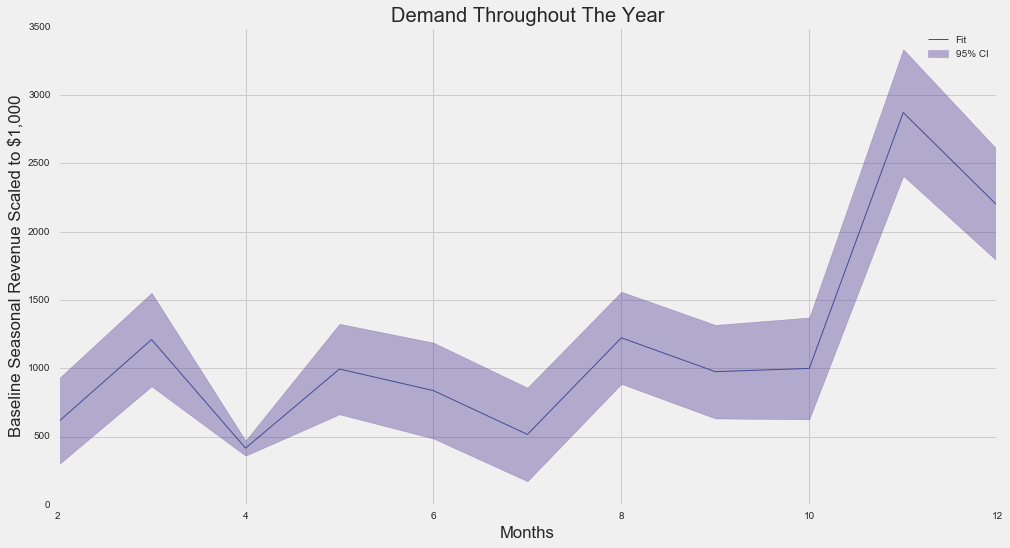

In [363]:
# Create the plot object
plt.rcParams['figure.figsize'] = (15.0, 8.0)
_, ax = plt.subplots()

# Plot the data, set the linewidth, color and transparency of the
# line, provide a label for the legend
ax.plot(months['mths'],months['value'], lw = 1, color = '#414e94', alpha = 1, label = 'Fit')
# Shade the confidence interval
ax.fill_between(months['mths'], months['max'], months['min'], color = '#564196', alpha = 0.4, label = '95% CI')
# Label the axes and provide a title
ax.set_title('Demand Throughout The Year')
ax.set_xlabel('Months')
ax.set_ylabel('Baseline Seasonal Revenue Scaled to $1,000')

# Display legend
ax.legend(loc = 'best')


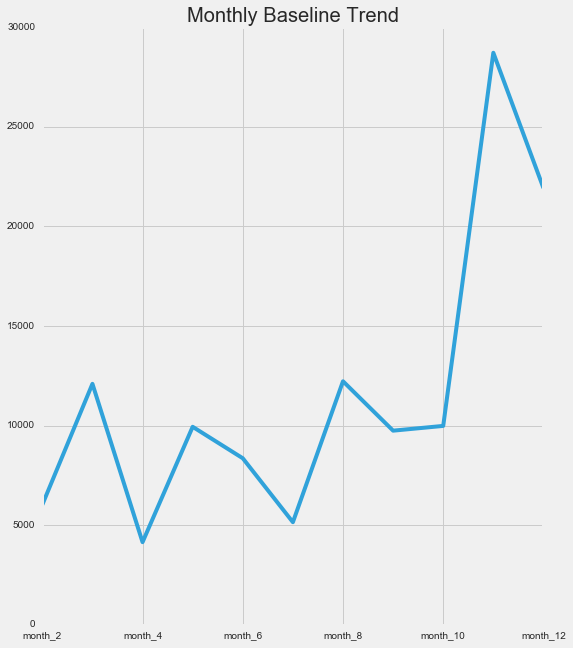

In [219]:
plt.rcParams['figure.figsize'] = (8.0, 10.0)
months.plot()
plt.title("Monthly Baseline Trend")

This is a Fail, Explained Variance is the worst in this model, but for for last experiment, lets see what happens with PCA.

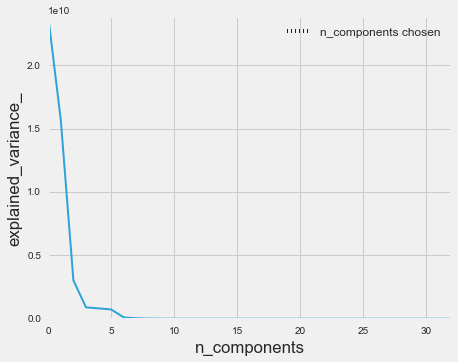

In [86]:
eNet = ElasticNet(random_state=2)
pca = decomposition.PCA(random_state=2)
pipe = Pipeline(steps=[('pca', pca), ('eNet', eNet)])

# Plot the PCA spectrum
pca.fit(X_train)

plt.figure(1, figsize=(8, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [5, 10, 15, 20, 25, 30,  33]
max_iters = [1, 5, 10, 15]
alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
l1_ratios = np.arange(0.0, 1.0, 0.1)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              eNet__l1_ratio=l1_ratios,
                              eNet__max_iter=max_iters,
                              eNet__alpha=alphas,
                             ))
estimator.fit(X_train, y_train)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()
Y_pred_pca = estimator.predict(X_test)

In [211]:
np.min(baseline_ev)

0.71078565690929929

In [71]:
print(estimator.best_estimator_)
print(estimator.best_score_) 
print(estimator.best_params_) 

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=33, random_state=2,
  svd_solver='auto', tol=0.0, whiten=False)), ('eNet', ElasticNet(alpha=0.01, copy_X=True, fit_intercept=True,
      l1_ratio=0.10000000000000001, max_iter=1, normalize=False,
      positive=False, precompute=False, random_state=2, selection='cyclic',
      tol=0.0001, warm_start=False))])
0.788832410862
{'pca__n_components': 33, 'eNet__l1_ratio': 0.10000000000000001, 'eNet__max_iter': 1, 'eNet__alpha': 0.01}


In [88]:
Y_pred_pca_test = estimator.predict(X_test)     
Y_pred_pca_train = estimator.predict(X_train) 

MAE_train = mean_absolute_error(y_train, Y_pred_pca_train,  multioutput='uniform_average')
MAE_test = mean_absolute_error(y_test, Y_pred_pca_test,  multioutput='uniform_average')
cm_train = explained_variance_score(y_train, Y_pred_pca_train,  multioutput='uniform_average')
cm_train = explained_variance_score(y_test, Y_pred_pca_test,  multioutput='uniform_average')
print("Mean Absolute Error: {} Test: {}".format(MAE_train,MAE_test ))
print("Explained Variance Score Train: {} Test: {}".format(cmols_train,cmols_test ))

Mean Absolute Error: 13908.5957632 Test: 16219.9036297
Explained Variance Score Train: 0.960611379944 Test: 0.887341028428


You see here that the PCA keeps picking 33, and the ElasticNet+PCA model does not improve over the standard ElasticNet run above. Interestingly the l1 did not go to 0, so there is still something that needs to be eliminated. 

# The Price Affect
Lets set a new price point, Bootstrap and rerun the last 12months of marketing, what is the net affect on revenue? 

Definition of Features: 
* subtotal: All-In Price inc Taxes and Shipping
* total_price: Basket Price net Taxes and Shipping
* discount: Discount is Code or %Off Sale
* transaction_amount: Amount Client Receives
* GA Revenue: = subtotal - discounts

3 Methods -
1. Perceived Prices: SubTotal, Total Price, and Discount go up, Transaction Price Stays the Same
2. Paid Prices: SubTotal, Total Price, and Transaction Price go up, Discount Stays the Same
3. Raise Prices: Everything Goes Up.


Remembering our H0 and H1 from above, the bargain hunter is represented by Perceived Prices, whereas the Homo Economicus Theory is associated with the Paid Prices Dataset.

In [91]:
paid10bs = amdcpd.drop(['orders'], axis=1)
paid10bs['subtotal'] = paid10bs['subtotal'] * 1.1
paid10bs['discount'] = paid10bs['discount'] * 2.3
paid10bs['total_price'] = paid10bs['subtotal'] - paid10bs['discount']

In [92]:
print("Perceived Prices +10%  Median subtotal:" + str(np.mean(paid10bs['subtotal'])) + " discount:" + str(np.mean(paid10bs['discount'])))
print("Perceived Prices +10%  Median total_price:" + str(np.mean(paid10bs['total_price'])) + " transaction_amount:" + str(np.mean(paid10bs['transaction_amount'])))

Perceived Prices +10%  Median subtotal:216.139162562 discount:35.7259339901
Perceived Prices +10%  Median total_price:180.413228571 transaction_amount:175.165738916


In [93]:
paid15bs = amdcpd.drop(['orders'], axis=1)
paid15bs['subtotal'] = paid15bs['subtotal'] * 1.2
paid15bs['discount'] = paid15bs['discount'] * 3.55
paid15bs['total_price'] = paid15bs['subtotal'] - paid15bs['discount']

In [94]:
print("Perceived Prices +20%  Median subtotal:" + str(np.mean(paid15bs['subtotal'])) + " discount:" + str(np.mean(paid15bs['discount'])))
print("Perceived Prices +20%  Median total_price:" + str(np.mean(paid15bs['total_price'])) + " transaction_amount:" + str(np.mean(paid15bs['transaction_amount'])))

Perceived Prices +20%  Median subtotal:235.78817734 discount:55.1422024631
Perceived Prices +20%  Median total_price:180.645974877 transaction_amount:175.165738916


In [95]:
pres10bs = amdcpd.drop(['orders'], axis=1)
pres10bs['subtotal'] = pres10bs['subtotal'] * 1.1
pres10bs['total_price'] = pres10bs['total_price'] * 1.1
pres10bs['transaction_amount'] = pres10bs['transaction_amount'] * 1.1

In [96]:
print("Paid Prices +10%  Median subtotal:" + str(np.mean(pres10bs['subtotal'])) + " discount:" + str(np.mean(pres10bs['discount'])))
print("Paid Prices +10%  Median total_price:" + str(np.mean(pres10bs['total_price'])) + " transaction_amount:" + str(np.mean(pres10bs['transaction_amount'])))

Paid Prices +10%  Median subtotal:216.139162562 discount:15.5330147783
Paid Prices +10%  Median total_price:198.352384729 transaction_amount:192.682312808


In [97]:
pres15bs = amdcpd.drop(['orders'], axis=1)
pres15bs['subtotal'] = pres15bs['subtotal'] * 1.2
pres15bs['total_price'] = pres15bs['total_price'] * 1.2
pres15bs['transaction_amount'] = pres15bs['transaction_amount'] * 1.2

In [98]:
print("Paid Prices +20% Median subtotal:" + str(np.mean(pres15bs['subtotal'])) + " discount:" + str(np.mean(pres15bs['discount'])))
print("Paid Prices +20% Median total_price:" + str(np.mean(pres15bs['total_price'])) + " transaction_amount:" + str(np.mean(pres15bs['transaction_amount'])))

Paid Prices +20% Median subtotal:235.78817734 discount:15.5330147783
Paid Prices +20% Median total_price:216.384419704 transaction_amount:210.1988867


In [99]:
raise10bs = amdcpd.drop(['orders'], axis=1)
raise10bs['subtotal'] = raise10bs['subtotal'] * 1.1
raise10bs['discount'] = raise10bs['discount'] * 1.3
raise10bs['total_price'] = raise10bs['subtotal'] - raise10bs['discount']
raise10bs['transaction_amount'] = raise10bs['transaction_amount'] * 1.08

In [100]:
print("Raise Everything +10% Median subtotal:" + str(np.mean(raise10bs['subtotal'])) + " discount:" + str(np.mean(raise10bs['discount'])))
print("Raise Everything +10%  Median total_price:" + str(np.mean(raise10bs['total_price'])) + " transaction_amount:" + str(np.mean(raise10bs['transaction_amount'])))
 

Raise Everything +10% Median subtotal:216.139162562 discount:20.1929192118
Raise Everything +10%  Median total_price:195.94624335 transaction_amount:189.17899803


In [101]:
bsdata = amdcpd.drop(['orders'], axis=1)

In [102]:
print("Baseline  Median subtotal:" + str(np.mean(bsdata['subtotal'])) + " discount:" + str(np.mean(bsdata['discount'])))
print("Baseline  Median total_price:" + str(np.mean(bsdata['total_price'])) + " transaction_amount:" + str(np.mean(bsdata['transaction_amount'])))
  

Baseline  Median subtotal:196.490147783 discount:15.5330147783
Baseline  Median total_price:180.320349754 transaction_amount:175.165738916


In [103]:
from sklearn.preprocessing import RobustScaler

Using the method and Hyperparameters that we estimated above, we now create a Bootstrap formula, that takes a dataset, sets a holdout number for the test case, sets the number of iterations, and estimates a CI.

In [106]:
def bootstraper(data, test_n, iterations=1, ci=0.95):
    eNet = ElasticNet(alpha=0.01, l1_ratio=0.6, fit_intercept=True,
                  max_iter=5, random_state=2, selection='cyclic')
    rbs = preprocessing.RobustScaler()
    pipe = Pipeline(steps=[('rbs', rbs), ('eNet', eNet)])
    
    # configure bootstrap
    n_iterations = iterations 
    n = test_n
    values = data.values
    
    # run bootstrap
    stats = list()
    ev_train = list()
    ev_test = list()
    for i in range(n_iterations):
        # prepare train and test sets
        test = values[np.random.randint(n, size=n)]
        train = np.array([x for x in values if x.tolist() not in test.tolist()])
        # fit model
        pipe.fit(train[:,:-1], train[:,-1])
        # evaluate model
        predictions_test = pipe.predict(test[:,:-1])
        score = np.sum(predictions_test)
        stats.append(score)
        
        evariance_test = explained_variance_score(test[:,-1], predictions_test,  multioutput='uniform_average')
        ev_test.append(evariance_test)
        
        predictions_train = pipe.predict(train[:,:-1])
        evariance_train = explained_variance_score(train[:,-1], predictions_train,  multioutput='uniform_average')
        ev_train.append(evariance_train)
        
    
    
    # plot scores
    plt.hist(stats)
    plt.show()
    # confidence intervals
    alpha = ci
    p = ((1.0-alpha)/2.0) * 100
    lower = max(0.0, np.percentile(stats, p))
    p = (alpha+((1.0-alpha)/2.0)) * 100
    upper = min(1.0, np.percentile(stats, p))
    print('{0} confidence interval {1} and {2}'.format(alpha*100, lower, upper))
    print('EV TRAIN MAX, {0:0.4f} EV MIN {1:0.4f}, EV Mean {2:0.4f}'.format(np.max(ev_train), np.min(ev_train), np.mean(ev_train)))
    print('EV TEST MAX, {0:0.4f} EV MIN {1:0.4f}, EV Mean {2:0.4f}'.format(np.max(ev_test), np.min(ev_test), np.mean(ev_test)))
    return stats, ev_train, ev_test


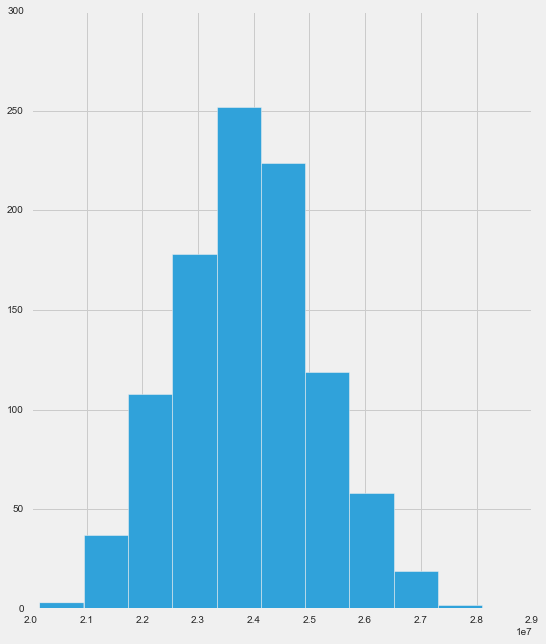

90.0 confidence interval 21899244.4881 and 1.0
EV TRAIN MAX, 0.9376 EV MIN 0.9257, EV Mean 0.9318
EV TEST MAX, 0.9336 EV MIN 0.7081, EV Mean 0.8636


In [109]:
baseline, baseline_ev_train, baseline_ev_train = bootstraper(bsdata, 365, iterations=1000, ci=0.9)

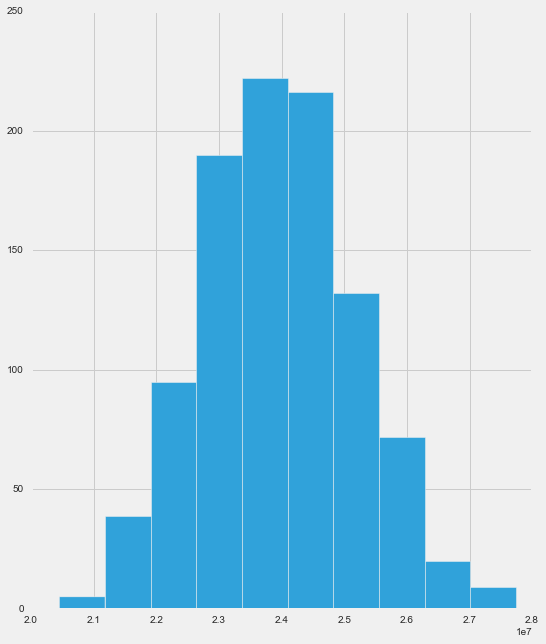

90.0 confidence interval 21980541.8362 and 1.0
EV TRAIN MAX, 0.9375 EV MIN 0.9241, EV Mean 0.9316
EV TEST MAX, 0.9298 EV MIN 0.6671, EV Mean 0.8648


In [110]:
tenup, tenup_ev_train, tenup_ev_train = bootstraper(paid10bs, 365, iterations=1000, ci=0.9)

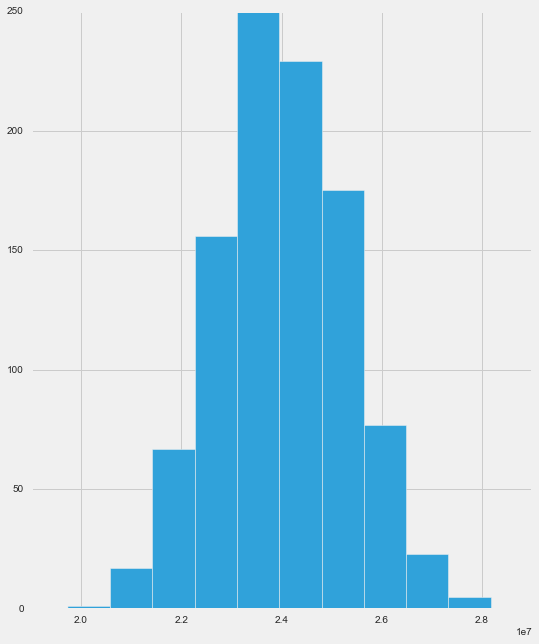

90.0 confidence interval 21875469.6182 and 1.0
EV TRAIN MAX, 0.9380 EV MIN 0.9255, EV Mean 0.9316
EV TEST MAX, 0.9325 EV MIN 0.7209, EV Mean 0.8647


In [111]:
fifup, fifup_ev_train, fifup_ev_train = bootstraper(paid15bs, 365, iterations=1000, ci=0.9)

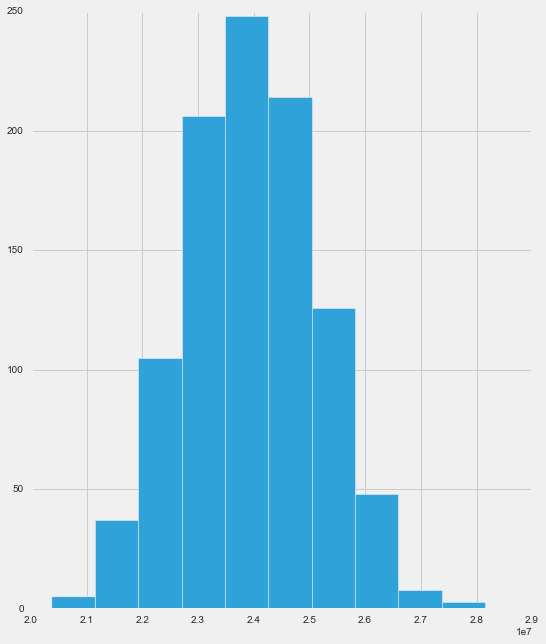

90.0 confidence interval 22063051.4194 and 1.0
EV TRAIN MAX, 0.9377 EV MIN 0.9256, EV Mean 0.9319
EV TEST MAX, 0.9297 EV MIN 0.6593, EV Mean 0.8638


In [112]:
tensee, tensee_ev_train, tensee_ev_train = bootstraper(pres10bs, 365, iterations=1000, ci=0.9)

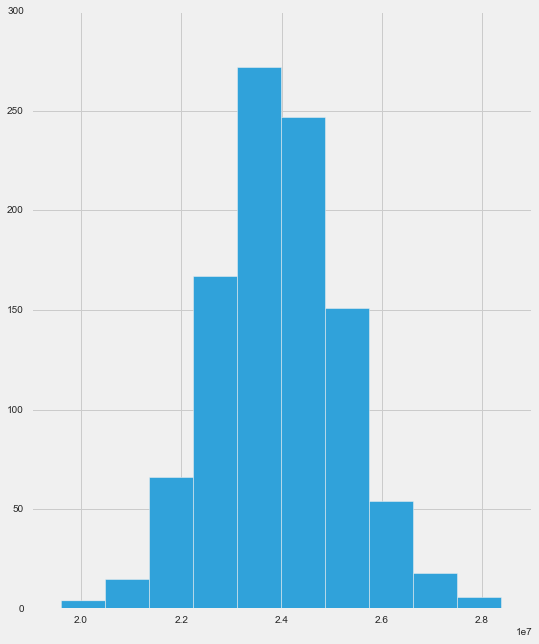

90.0 confidence interval 21953113.1223 and 1.0
EV TRAIN MAX, 0.9368 EV MIN 0.9269, EV Mean 0.9318
EV TEST MAX, 0.9346 EV MIN 0.7014, EV Mean 0.8662


In [113]:
fifsee, fifsee_ev_train, fifsee_ev_train = bootstraper(pres15bs, 365, iterations=1000, ci=0.9)

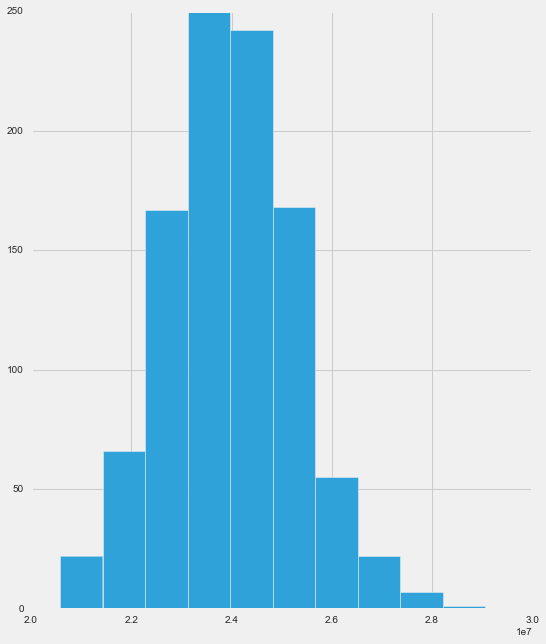

90.0 confidence interval 21942274.4125 and 1.0
EV TRAIN MAX, 0.9373 EV MIN 0.9266, EV Mean 0.9318
EV TEST MAX, 0.9328 EV MIN 0.6804, EV Mean 0.8656


In [114]:
raiseup, raiseup_ev_train, raiseup_ev_train = bootstraper(raise10bs, 365, iterations=1000, ci=0.9)

In [115]:
bs_results = pd.DataFrame((zip(baseline, tenup, fifup, tensee, fifsee, raiseup)))
bs_results.columns = ['Baseline','Precieved Prices +10','Precieved Prices +20','Paid Prices +10','Paid Prices +20','Raise Everything +10']

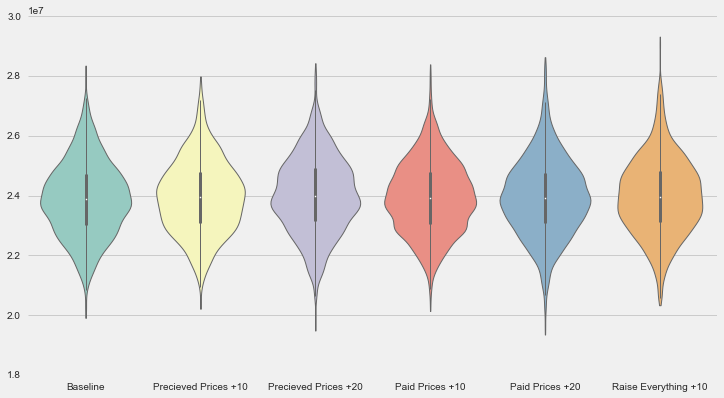

In [116]:
f, ax = plt.subplots(figsize=(11, 6))
sns.violinplot(data=bs_results, palette="Set3", bw=.2, cut=1, linewidth=1)
sns.despine(left=True, bottom=True)

In [117]:
bs_demand = pd.DataFrame()
bs_demand['Revenue'] = bs_results.apply(np.mean).astype('int64')
bs_demand['STD'] = bs_results.apply(np.std).astype('int64')

bs_demand.loc['Baseline', 'total_price'] = np.mean(bsdata['total_price'])
bs_demand.loc['Baseline', 'subtotal'] = np.mean(bsdata['subtotal'])
bs_demand.loc['Baseline', 'discount'] = np.mean(bsdata['discount'])
bs_demand.loc['Baseline', 'transaction_amount'] = np.mean(bsdata['transaction_amount'])

bs_demand.loc['Precieved Prices +10', 'total_price'] = np.mean(paid10bs['total_price'])
bs_demand.loc['Precieved Prices +10', 'subtotal'] = np.mean(paid10bs['subtotal'])
bs_demand.loc['Precieved Prices +10', 'discount'] = np.mean(paid10bs['discount'])
bs_demand.loc['Precieved Prices +10', 'transaction_amount'] = np.mean(paid10bs['transaction_amount'])


bs_demand.loc['Precieved Prices +20', 'total_price'] = np.mean(paid15bs['total_price'])
bs_demand.loc['Precieved Prices +20', 'subtotal'] = np.mean(paid15bs['subtotal'])
bs_demand.loc['Precieved Prices +20', 'discount'] = np.mean(paid15bs['discount'])
bs_demand.loc['Precieved Prices +20', 'transaction_amount'] = np.mean(paid15bs['transaction_amount'])

bs_demand.loc['Paid Prices +10', 'total_price'] = np.mean(pres10bs['total_price'])
bs_demand.loc['Paid Prices +10', 'subtotal'] = np.mean(pres10bs['subtotal'])
bs_demand.loc['Paid Prices +10', 'discount'] = np.mean(pres10bs['discount'])
bs_demand.loc['Paid Prices +10', 'transaction_amount'] = np.mean(pres10bs['transaction_amount'])

bs_demand.loc['Paid Prices +20', 'total_price'] = np.mean(pres15bs['total_price'])
bs_demand.loc['Paid Prices +20', 'subtotal'] = np.mean(pres15bs['subtotal'])
bs_demand.loc['Paid Prices +20', 'discount'] = np.mean(pres15bs['discount'])
bs_demand.loc['Paid Prices +20', 'transaction_amount'] = np.mean(pres15bs['transaction_amount'])

bs_demand.loc['Raise Everything +10', 'total_price'] = np.mean(raise10bs['total_price'])
bs_demand.loc['Raise Everything +10', 'subtotal'] = np.mean(raise10bs['subtotal'])
bs_demand.loc['Raise Everything +10', 'discount'] = np.mean(raise10bs['discount'])
bs_demand.loc['Raise Everything +10', 'transaction_amount'] = np.mean(raise10bs['transaction_amount'])



In [4]:
#bs_demand
#Data Removed

In [5]:
bs_demand['Orders'] = (bs_demand['Revenue'] / bs_demand['total_price']).astype('int64')
bs_demand['COGS'] = (bs_demand['Orders'] * 94).astype('int64') #$94 is taken as a placeholder
bs_demand['Profit'] = (bs_demand['Revenue'] - bs_demand['COGS']).astype('int64')

bs_demand
#Data Removed

"bs_demand['Orders'] = (bs_demand['Revenue'] / bs_demand['total_price']).astype('int64')\nbs_demand['COGS'] = (bs_demand['Orders'] * 94).astype('int64') #$94 is taken as a placeholder\nbs_demand['Profit'] = (bs_demand['Revenue'] - bs_demand['COGS']).astype('int64')\n\nbs_demand"

One can see how the Revenues are responding to the change in Total Prices (The Final Consumer Price), but less so to the Subtotal (MSRP/List Prices), which lets us conclude that the actual dollars exchanged, not the Perceived Value of the Discount is what changes behavior. This is what you would expect in the world of Rational Economic Actors. Meaning, the 'I Got A Great Deal!' theory of purchase behavior does not prove out in the data.

But what matters is not just Topline Revenue, we need to know the quantity demanded, Orders in this Dataset. Also, Costs of Good Sold does NOT change simply because we change the price, in fact it stays the same, and that has an impact on profit margins, and therefore Profits.


## Draw the Curve

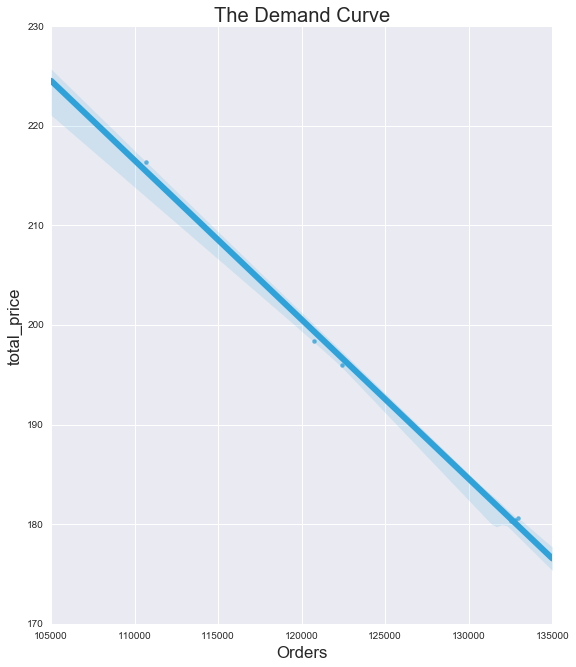

In [120]:
sns.set_style('darkgrid', {'legend.frameon':True})
ax = sns.regplot(x="Orders", y="total_price", data=bs_demand)
plt.title('The Demand Curve')
#ax = sns.regplot(x="Orders", y="subtotal", data=demand)
#ax = sns.regplot(x="Orders", y="transaction_amount", data=demand)
plt.show()

In [121]:
from scipy.optimize import curve_fit
def f(x, A, B): # this is your 'straight line' y=f(x)
    return B*x + A
A,B = curve_fit(f, bs_demand.total_price,bs_demand.Orders)[0] # your data x, y to fit
print('Beta is: ' + str(B))

Beta is: -623.528903133


This exactly what we would expect an inverse relationship between price and quality demanded. This has a number of interpertable properties. Namely, a $1 increase in the price will equate to a 627 Order decline in the total number of Orders Demanded. 

What is MUCH BETTER is the ability to derive the 
### Price Elasticity of Demand (PED)

<img src="http://www.dummies.com/wp-content/uploads/price-elasticity-of-demand-formula.jpg" alt="price-elasticity-of-demand-formula" title="Price Elasticity of Demand Formula" />







In [122]:
Q = (bs_demand.loc['Paid Prices +20','Orders'] - bs_demand.loc['Baseline','Orders']) / (bs_demand.loc['Paid Prices +20','Orders'] + bs_demand.loc['Baseline','Orders'])
P = (bs_demand.loc['Paid Prices +20','total_price'] - bs_demand.loc['Baseline','total_price']) / (bs_demand.loc['Paid Prices +20','total_price'] + bs_demand.loc['Baseline','total_price'])
n = Q/P
print("Delta Q: " + " " + str(Q))
print("Delta P: " + " " + str(P))
print("Price Elasticity of Demand is: " + " " + str(n))

Delta Q:  -0.0897173357019
Delta P:  0.0909090909091
Price Elasticity of Demand is:  -0.986890692721


This is very close to Unitary Elasticity, meaning a 1% increase in the price is expected to see a 1.01% decline in the Quanity Demanded. 

Which is actaully __very unexpected__, Women's Fashion is highly competitive, there are many substitutions for any given bag, shoe, dress, etc. One might expect a very elastic consumer, but that does not appear to be the case. 

> __Theory__ - One major complicating factor is the role of Styles, which makes it so that a Bag from X is not the same as a Bag from Y, even though they serve the same basic function. And that gravation to a specific Style or Brand is what gives a designer Pricing Power.  

### Margins and Profit
There is one last component, namely although price has been increased, our marginal COGS is the same, therefore the change in price also has an affect on margin and therefore profit. 

In [123]:
bs_demand['Gross Margin'] = ( bs_demand['Profit']/bs_demand['Revenue']) *100

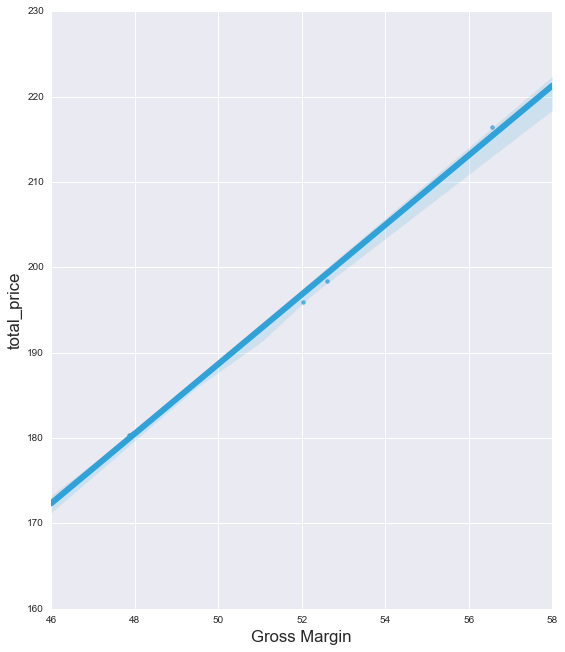

In [124]:
ax = sns.regplot(x="Gross Margin", y="total_price", data=bs_demand)

What this shows is that Gross Margin improves by 2.2% for every $10 increase in the price. In the cases where we are only adjusting the Perceived Prices, we do not see a lot of movement, but when we move the actual prices, we can see the net effect on GM and therefore, profits.

In [6]:
#bs_demand
#Data Removed

In [7]:
"""
print("Change From Baseline to Paid Prices +10%")
print("Revenue: $" + " " + str(bs_demand.loc['Paid Prices +10','Revenue'] - bs_demand.loc['Baseline','Revenue']))
print("Orders: " + " " + str(bs_demand.loc['Paid Prices +10','Orders'] - bs_demand.loc['Baseline','Orders']))
print("Profit: $" + " " + str(bs_demand.loc['Paid Prices +10','Profit'] - bs_demand.loc['Baseline','Profit']))
"""
#Data Removed

'print("Change From Baseline to Paid Prices +10%")\nprint("Revenue: $" + " " + str(bs_demand.loc[\'Paid Prices +10\',\'Revenue\'] - bs_demand.loc[\'Baseline\',\'Revenue\']))\nprint("Orders: " + " " + str(bs_demand.loc[\'Paid Prices +10\',\'Orders\'] - bs_demand.loc[\'Baseline\',\'Orders\']))\nprint("Profit: $" + " " + str(bs_demand.loc[\'Paid Prices +10\',\'Profit\'] - bs_demand.loc[\'Baseline\',\'Profit\']))\n'

In [9]:
"""
print("Change From Baseline to Paid Prices +20%")
print("Revenue: $" + " " + str(bs_demand.loc['Paid Prices +20','Revenue'] - bs_demand.loc['Baseline','Revenue']))
print("Orders: " + " " + str(bs_demand.loc['Paid Prices +20','Orders'] - bs_demand.loc['Baseline','Orders']))
print("Profit: $" + " " + str(bs_demand.loc['Paid Prices +20','Profit'] - bs_demand.loc['Baseline','Profit']))
"""
#Data Removed

'\nprint("Change From Baseline to Paid Prices +20%")\nprint("Revenue: $" + " " + str(bs_demand.loc[\'Paid Prices +20\',\'Revenue\'] - bs_demand.loc[\'Baseline\',\'Revenue\']))\nprint("Orders: " + " " + str(bs_demand.loc[\'Paid Prices +20\',\'Orders\'] - bs_demand.loc[\'Baseline\',\'Orders\']))\nprint("Profit: $" + " " + str(bs_demand.loc[\'Paid Prices +20\',\'Profit\'] - bs_demand.loc[\'Baseline\',\'Profit\']))\n'

In [10]:
"""
print("Change From Baseline to Raise Everything 10%")
print("Revenue: $" + " " + str(bs_demand.loc['Raise Everything +10','Revenue'] - bs_demand.loc['Baseline','Revenue']))
print("Orders: " + " " + str(bs_demand.loc['Raise Everything +10','Orders'] - bs_demand.loc['Baseline','Orders']))
print("Profit: $" + " " + str(bs_demand.loc['Raise Everything +10','Profit'] - bs_demand.loc['Baseline','Profit']))
"""
#Data Removed

'\nprint("Change From Baseline to Raise Everything 10%")\nprint("Revenue: $" + " " + str(bs_demand.loc[\'Raise Everything +10\',\'Revenue\'] - bs_demand.loc[\'Baseline\',\'Revenue\']))\nprint("Orders: " + " " + str(bs_demand.loc[\'Raise Everything +10\',\'Orders\'] - bs_demand.loc[\'Baseline\',\'Orders\']))\nprint("Profit: $" + " " + str(bs_demand.loc[\'Raise Everything +10\',\'Profit\'] - bs_demand.loc[\'Baseline\',\'Profit\']))\n'

# Conclusion 
The final solution depends on the company’s goal: <br/>
* Profit Maximizing – The company might sell less, but it makes more money by getting higher prices. <br/>
* Revenue Maximizing – The company sells more units, but each unit incremental provides less profit. <br/>
